In [1]:
import os, sys, time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pylab
import matplotlib.pyplot as plt

from scipy.misc import imread, imresize
from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist

from invert import invert

from indexdata import load_image_to_label
from indexdataset import load_image_dataset_label_index
from voclabels import voc_labels

import loadseg
import expdir
import intersect
import upsample
from labelprobe import cached_memmap

import sys
from viewprobe import NetworkProbe

import word2vec
from word2vec import WordVectors

import matplotlib
from matplotlib.ticker import FuncFormatter, MaxNLocator

from linearprobe_pytorch import CustomLayer

from figures import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ImportError: No module named torch

In [ ]:
import matplotlib.pylab as pylab
params = {'axes.labelsize': 16,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14,
         'legend.fontsize':14}
pylab.rcParams.update(params)

In [ ]:
gpu = 1

cuda = True if gpu is not None else False
use_mult_gpu = isinstance(gpu, list)
if cuda:
    if use_mult_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu
print(torch.cuda.device_count(), use_mult_gpu, cuda)

In [ ]:
directory='/home/ruthfong/NetDissect/probes/pytorch_alexnet_imagenet'
if not os.path.exists(directory):
    directory='/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet'
    assert(os.path.exists(directory))
blob='features.11'

In [ ]:
ed = expdir.ExperimentDirectory(directory)

info = ed.load_info()
ds = loadseg.SegmentationData(info.dataset)
categories = np.array(ds.category_names())

L = ds.label_size()
N = ds.size()

label_names = np.array([ds.label[i]['name'] for i in range(L)])

In [ ]:
train_idx = np.array([ds.split(i) == 'train' for i in range(N)])
val_idx = np.array([ds.split(i) == 'val' for i in range(N)])
train_ind = np.array([True if ds.split(i) == 'train' else False for i in range(N)])
val_ind = np.array([True if ds.split(i) == 'val' else False for i in range(N)])

In [ ]:
image_to_label = load_image_to_label(directory)
pc = ds.primary_categories_per_index()
pc[0] = -1

In [2]:
num_train_examples = np.sum(image_to_label[train_ind,:], axis=0)
num_examples = np.sum(image_to_label, axis=0)

NameError: name 'image_to_label' is not defined

In [8]:
def load_seg_results(directory, blobs):
    e = expdir.ExperimentDirectory(directory)

    res_linear_ind_ious = {}
    res_single_ind_ious = {}
    res_linear_set_ious = {}
    res_weights = {}

    res_single_set_train_ious = {}
    res_single_set_val_ious = {}

    for blob in blobs:
        blob_info = e.load_info(blob=blob)
        shape = blob_info.shape
        K = shape[1]
        res_linear_ind_ious[blob] = e.open_mmap(blob=blob, part='linear_ind_ious', mode='r', dtype='float32', shape=(L,N))
        res_single_ind_ious[blob] = e.open_mmap(blob=blob, part='single_ind_ious', mode='r', dtype='float32', shape=(L,N,K))
        res_linear_set_ious[blob] = e.open_mmap(blob=blob, part='linear_set_val_ious', mode='r', dtype='float32', shape=(L,))
        res_single_set_train_ious[blob] = e.open_mmap(blob=blob, part='single_set_train_ious', mode='r', dtype='float32', shape=(L,K))
        res_single_set_val_ious[blob] = e.open_mmap(blob=blob, part='single_set_val_ious', mode='r', dtype='float32', shape=(L,K))
        res_weights[blob] = e.open_mmap(blob=blob, part='linear_weights', mode='r', dtype='float32', shape=(L,K))

    res = {}
    res['expdir'] = e
    res['blobs'] = blobs
    res['linear_ind_ious'] = res_linear_ind_ious
    res['single_ind_ious'] = res_single_ind_ious
    res['linear_set_ious'] = res_linear_set_ious
    res['weights'] = res_weights
    res['single_set_train_ious'] = res_single_set_train_ious
    res['single_set_val_ious'] = res_single_set_val_ious
    
    return res

In [9]:
def load_class_results(directory, blobs, epochs=30, suffix='_lr_1e-1_sgd_quant_1_epochs_30_iter_15_num_filters', num_filters=[1]):
    e = expdir.ExperimentDirectory(directory)
    F = len(num_filters) + 1

    res_disc_weights_all = {}
    res_disc_bias_all = {}
    res_disc_results_all = {}

    for blob in blobs:
        blob_info = e.load_info(blob=blob)
        shape = blob_info.shape
        K = shape[1]

        res_disc_weights_all[blob] = e.open_mmap(blob=blob, part='linear_weights_disc%s' % (suffix + '_%d' % F), mode='r', dtype='float32', shape=(L, F, K))
        res_disc_bias_all[blob] = e.open_mmap(blob=blob, part='linear_bias_disc%s' % (suffix + '_%d' % F), mode='r', dtype='float32', shape=(L, F))
        res_disc_results_all[blob] = e.open_mmap(blob=blob, part='linear_results_disc%s' % (suffix + '_%d' % F), mode='r', dtype='float32', shape=(L, F, 4, epochs))
        
    res = {}
    res['expdir'] = e
    res['blobs'] = blobs
    res['disc_weights'] = res_disc_weights_all
    res['disc_bias'] = res_disc_bias_all
    res['disc_results'] = res_disc_results_all
    
    return res

In [10]:
results_dir = '/scratch/shared/slow/ruthfong/'

In [319]:
alexnet_blobs = ['features.1', 'features.4', 'features.7', 'features.9', 'features.11']
alexnet_seg_results = load_seg_results(os.path.join(results_dir, 'pytorch_alexnet_imagenet'), alexnet_blobs)

caffe_blobs = ['conv1', 'conv2', 'conv4', 'conv5'] # working on conv3
caffe_seg_results = load_seg_results('/scratch/shared/slow/ruthfong/caffe_reference_imagenet', ['conv5'])
caffep_seg_results = load_seg_results('/scratch/shared/slow/ruthfong/caffe_reference_places365', caffe_blobs)

vgg_blobs = ['conv5_1', 'conv5_2', 'conv5_3']
vgg_seg_results = load_seg_results('/scratch/shared/slow/ruthfong/vgg16_imagenet', vgg_blobs)
vggp_seg_results = load_seg_results('/scratch/shared/slow/ruthfong/vgg16_places365', ['conv5_3'])

googlenet_blobs = ['inception_4c-output', 'inception_4e-output', 'inception_5a-output', 'inception_5b-output']
googlenet_seg_results = load_seg_results('/scratch/shared/slow/ruthfong/googlenet_imagenet', googlenet_blobs)
googlenetp_seg_results = load_seg_results('/scratch/shared/slow/ruthfong/googlenet_places365', [googlenet_blobs[-1]])

In [12]:
ss_blobs = ['conv5']
egomotion_blobs = ['cls_conv5']

# running probelinear now for tracking
tracking_seg_results = load_seg_results(os.path.join(results_dir, 'weakly_videotracking'),
                                       ss_blobs)
audio_seg_results = load_seg_results(os.path.join(results_dir, 'weakly_audio'),
                                       ss_blobs)
objectcentric_seg_results = load_seg_results(os.path.join(results_dir, 'weakly_objectcentric'),
                                       ss_blobs)
moving_seg_results = load_seg_results(os.path.join(results_dir, 'weakly_learningbymoving'),
                                       ss_blobs)
egomotion_seg_results = load_seg_results(os.path.join(results_dir, 'weakly_egomotion'),
                                       egomotion_blobs)

In [320]:
alexnet_blobs_fc = ['features.1', 'features.4', 'features.7', 'features.9', 'features.11', 'classifier.2', 'classifier.5', 'classifier.6']
alexnet_class_results = load_class_results(os.path.join(results_dir, 'pytorch_alexnet_imagenet'), alexnet_blobs)
alexnet_class_fc_results = load_class_results(os.path.join(results_dir, 'pytorch_alexnet_imagenet'), alexnet_blobs_fc)

caffe_class_results = load_class_results(os.path.join(results_dir, 'caffe_reference_imagenet'), ['conv5'])
caffep_class_results = load_class_results(os.path.join(results_dir, 'caffe_reference_places365'), ['conv5'])
vgg_class_results = load_class_results(os.path.join(results_dir, 'vgg16_imagenet'), ['conv5_3'])
vggp_class_results = load_class_results(os.path.join(results_dir, 'vgg16_places365'), ['conv5_3'])
googlenet_class_results = load_class_results(os.path.join(results_dir, 'googlenet_imagenet'), ['inception_5b-output'])
googlenetp_class_results = load_class_results(os.path.join(results_dir, 'googlenet_places365'), ['inception_5b-output'])

In [677]:
probe_results = googlenet_seg_results
blob_info = probe_results['expdir'].load_info(blob=probe_results['blobs'][-3])
print blob_info.shape

(63305, 832, 14, 14)


In [136]:
ss_blobs = ['conv5']
egomotion_blobs = ['cls_conv5']

# running probelinear now for tracking
tracking_class_results = load_class_results(os.path.join(results_dir, 'weakly_videotracking'),
                                       ss_blobs)
audio_class_results = load_class_results(os.path.join(results_dir, 'weakly_audio'),
                                       ss_blobs)
objectcentric_class_results = load_class_results(os.path.join(results_dir, 'weakly_objectcentric'),
                                       ss_blobs)
moving_class_results = load_class_results(os.path.join(results_dir, 'weakly_learningbymoving'),
                                       ss_blobs)
egomotion_class_results = load_class_results(os.path.join(results_dir, 'weakly_egomotion'),
                                       egomotion_blobs)

In [17]:
def show_image(img_path):
    f, ax = plt.subplots(1,1)
    ax.imshow(imread(img_path))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Results across different networks and training datasets

In [322]:
seg_results = [caffe_seg_results, caffep_seg_results, vgg_seg_results, vggp_seg_results, 
               googlenet_seg_results, googlenetp_seg_results, 
               tracking_seg_results, audio_seg_results, objectcentric_seg_results, 
               moving_seg_results, egomotion_seg_results]

In [321]:
class_results = [caffe_class_results, caffep_class_results, vgg_class_results, vggp_class_results, 
               googlenet_class_results, googlenetp_class_results, 
               tracking_class_results, audio_class_results, objectcentric_class_results, 
               moving_class_results, egomotion_class_results]

In [20]:
network_names = ('alexnet_imagenet', 'alexnet_places', 'vgg16_imagenet', 'vgg16_places', 
                    'googlenet_imagenet', 'googlenet_places', 'tracking', 'audio', 'objectcentric', 
                    'moving', 'egomotion')

here
here
here
here


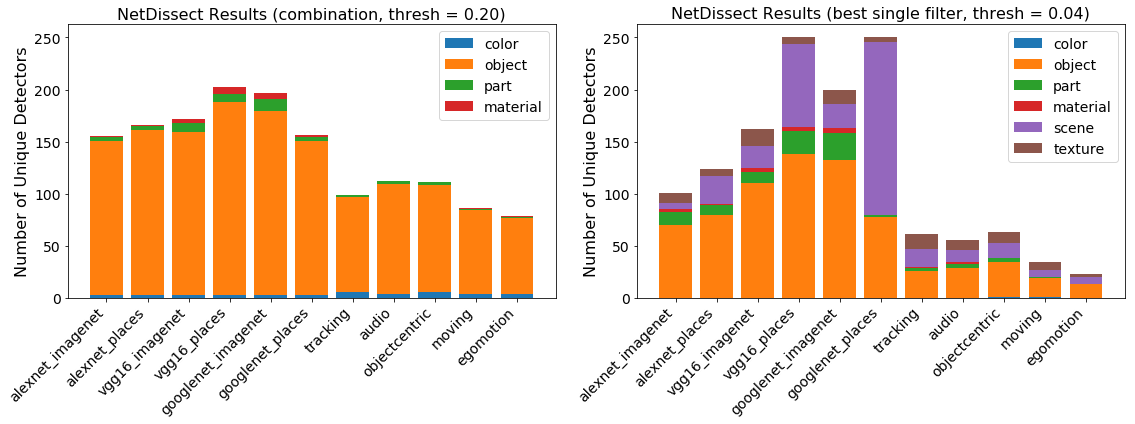

In [678]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,6))

comb_thresh = 0.2
single_thresh = 0.04

num_detectors = np.zeros((4, len(seg_results)))

j = 0
for res in seg_results:
    for cat in range(4):
        blob_i = -3 if res == googlenet_seg_results else -1
        num_detectors[cat,j] = np.sum(res['linear_set_ious'][res['blobs'][blob_i]][pc == cat] >= comb_thresh)
    j += 1
    
for cat in range(4):
    if cat == 0:
        ax[0].bar(np.arange(len(seg_results)), num_detectors[cat,:], label=categories[cat])
    else:
        ax[0].bar(np.arange(len(seg_results)), num_detectors[cat,:], bottom=np.sum(num_detectors[:cat,:], axis=0), label=categories[cat])

ax[0].legend()
ax[0].set_ylabel('Number of Unique Detectors')
ax[0].set_title('NetDissect Results (combination, thresh = %.2f)' % comb_thresh)
plt.sca(ax[0])
plt.xticks(np.arange(len(seg_results)), network_names, rotation=45, horizontalalignment='right')
#plt.show()

new_cat_idx = range(6)
new_idx = np.arange(len(new_cat_idx))
counts = np.array([np.sum(pc == i) for i in new_cat_idx])

num_detectors = np.zeros((len(categories), len(seg_results)))

j = 0
for res in seg_results:
    blob_i = -3 if res == googlenet_seg_results else -1
    best_concepts = np.argmax(res['single_set_train_ious'][res['blobs'][blob_i]], axis=0)
    best_single_ious = np.array([res['single_set_val_ious'][res['blobs'][blob_i]][best_concepts[i],i] 
                  for i in range(res['single_set_train_ious'][res['blobs'][blob_i]].shape[1])])
    best_concept_ious = np.zeros(L)
    for i in range(L):
        if np.sum(best_concepts == i) == 0:
            continue
        idx = np.where(best_concepts == i)[0]
        best_concept_ious[i] = np.max(best_single_ious[idx])
    for cat in range(len(categories)):
        num_detectors[cat,j] = np.sum(best_concept_ious[pc == cat] >= single_thresh)
    j += 1

for cat in range(len(categories)):
    if cat == 0:
        ax[1].bar(np.arange(len(seg_results)), num_detectors[cat,:], label=categories[cat])
    else:
        ax[1].bar(np.arange(len(seg_results)), num_detectors[cat,:], bottom=np.sum(num_detectors[:cat,:], axis=0), label=categories[cat])

ax[1].legend()
ax[1].set_ylabel('Number of Unique Detectors')
ax[1].set_title('NetDissect Results (best single filter, thresh = %.2f)' % single_thresh)
plt.sca(ax[1])
plt.xticks(np.arange(len(seg_results)), network_names, rotation=45, horizontalalignment='right')

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

plt.tight_layout()
plt.show()

In [689]:
def show_seg_results_for_all_blobs(res, num_single_cats=4):
    f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

    cat_idx = range(4)

    idx = np.arange(len(cat_idx))
    width = 1/float(len(res['blobs'])+1)
    counts = np.array([np.sum(pc == i) for i in cat_idx])

    j = 0
    for blob in res['blobs']:
        dist_mus = np.array([np.mean([res['linear_set_ious'][blob][pc == i]]) for i in cat_idx])
        dist_sigmas = np.array([np.std([res['linear_set_ious'][blob][pc == i]]) for i in cat_idx])
        ax[0].bar(idx + j*width, dist_mus, width, yerr=np.true_divide(dist_sigmas, np.sqrt(counts)), label=blob)
        j += 1
    #ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
    #ax[0].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
    ax[0].set_ylabel('Set IOU')
    ax[0].set_title('Segmentation Results of by Concept Categories (combination)')
    ax[0].set_xticks(idx+width*(len(res['blobs'])-1)/2.)
    ax[0].set_xticklabels(categories[cat_idx])
    #plt.show()

    new_cat_idx = range(num_single_cats)
    new_idx = np.arange(len(new_cat_idx))
    new_counts = np.array([np.sum(pc == i) for i in new_cat_idx])

    j = 0
    for blob in res['blobs']:
        best_filters = np.argmax(res['single_set_train_ious'][blob], axis=1)
        best_single_ious = np.array([res['single_set_train_ious'][blob][i,best_filters[i]]
                      for i in range(L)])
        single_mus = np.array([np.mean([x for x in best_single_ious[pc == i] if not np.isnan(x)]) for i in new_cat_idx])
        single_sigmas = np.array([np.std([x for x in best_single_ious[pc == i] if not np.isnan(x)]) for i in new_cat_idx])
        ax[1].bar(new_idx + j*width, single_mus, width, yerr=np.true_divide(single_sigmas, np.sqrt(new_counts)), label=blob)
        j += 1
    #ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
    #ax[1].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
    ax[1].legend(loc='upper center', ncol=2, fontsize='12')

    ax[1].set_ylabel('Set IOU')
    ax[1].set_title('Segmentation Results by Concept Categories (best single filter)')
    #ax[1].set_yticks(ax[0].get_yticks())
    ax[1].set_xticks(new_idx+width*(len(res['blobs'])-1)/2.)
    ax[1].set_xticklabels(categories[new_cat_idx])

    plt.setp(ax[0].get_yticklabels(), visible=True)
    plt.setp(ax[1].get_yticklabels(), visible=True)

    #plt.ylim([0.5,1.0])
    #formatter = FuncFormatter(to_percent)
    #plt.gca().yaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.show()

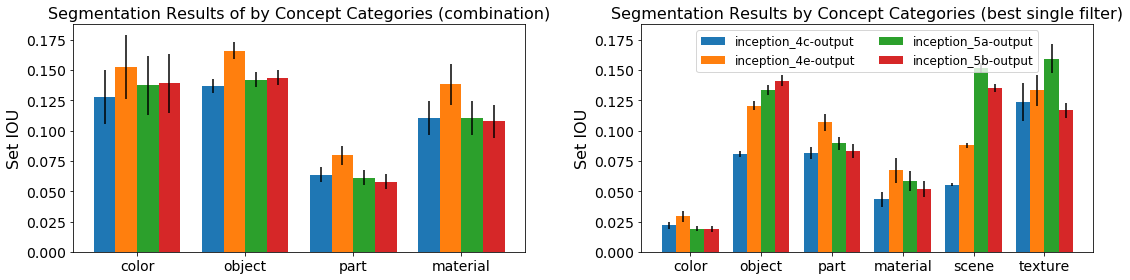

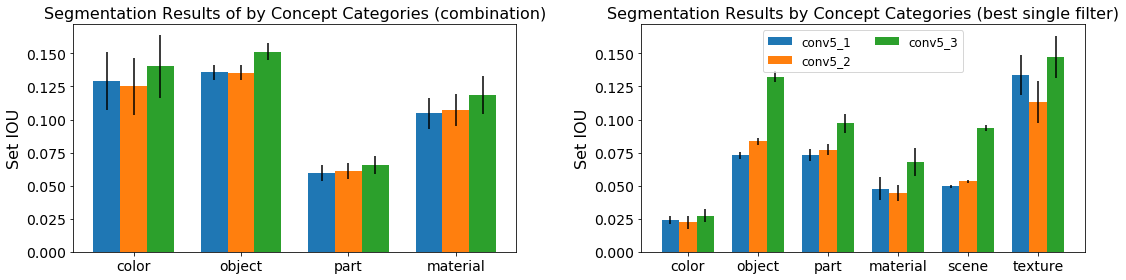

In [690]:
show_seg_results_for_all_blobs(googlenet_seg_results, num_single_cats=6)
show_seg_results_for_all_blobs(vgg_seg_results, num_single_cats=6)

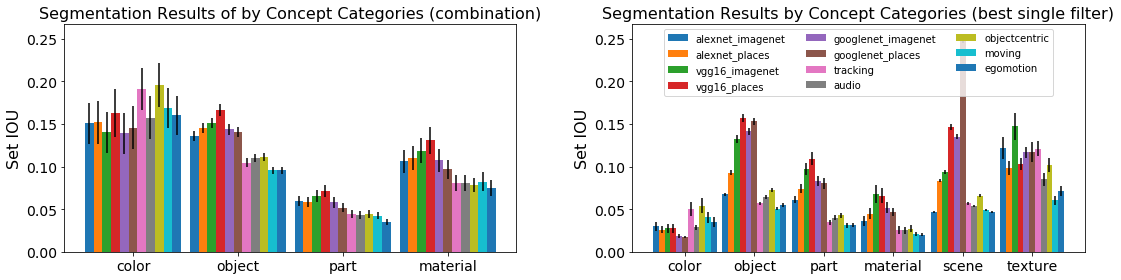

In [691]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

cat_idx = range(4)

idx = np.arange(len(cat_idx))
width = 1/float(len(seg_results)+1)
counts = np.array([np.sum(pc == i) for i in cat_idx])

j = 0
for res in seg_results:
    blob_i = -1
    #blob_i = -3 if res == googlenet_seg_results else -1
    dist_mus = np.array([np.mean([res['linear_set_ious'][res['blobs'][blob_i]][pc == i]]) for i in cat_idx])
    dist_sigmas = np.array([np.std([res['linear_set_ious'][res['blobs'][blob_i]][pc == i]]) for i in cat_idx])
    ax[0].bar(idx + j*width, dist_mus, width, yerr=np.true_divide(dist_sigmas, np.sqrt(counts)), label=network_names[j])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[0].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
ax[0].set_ylabel('Set IOU')
ax[0].set_title('Segmentation Results of by Concept Categories (combination)')
ax[0].set_xticks(idx+width*(len(seg_results)-1)/2.)
ax[0].set_xticklabels(categories[cat_idx])
#plt.show()

new_cat_idx = range(6)
new_idx = np.arange(len(new_cat_idx))
new_counts = np.array([np.sum(pc == i) for i in new_cat_idx])

j = 0
for res in seg_results:
    blob_i = -1
    #blob_i = -3 if res == googlenet_seg_results else -1
    best_filters = np.argmax(res['single_set_train_ious'][res['blobs'][blob_i]], axis=1)
    best_single_ious = np.array([res['single_set_train_ious'][res['blobs'][blob_i]][i,best_filters[i]]
                  for i in range(L)])
    single_mus = np.array([np.mean([x for x in best_single_ious[pc == i] if not np.isnan(x)]) for i in new_cat_idx])
    single_sigmas = np.array([np.std([x for x in best_single_ious[pc == i] if not np.isnan(x)]) for i in new_cat_idx])
    ax[1].bar(new_idx + j*width, single_mus, width, yerr=np.true_divide(single_sigmas, np.sqrt(new_counts)), label=network_names[j])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[1].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
ax[1].legend(loc='upper center', ncol=3, fontsize='10')

ax[1].set_ylabel('Set IOU')
ax[1].set_title('Segmentation Results by Concept Categories (best single filter)')
#ax[1].set_yticks(ax[0].get_yticks())
ax[1].set_xticks(new_idx+width*(len(seg_results)-1)/2.)
ax[1].set_xticklabels(categories[new_cat_idx])

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

#plt.ylim([0.5,1.0])
#formatter = FuncFormatter(to_percent)
#plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

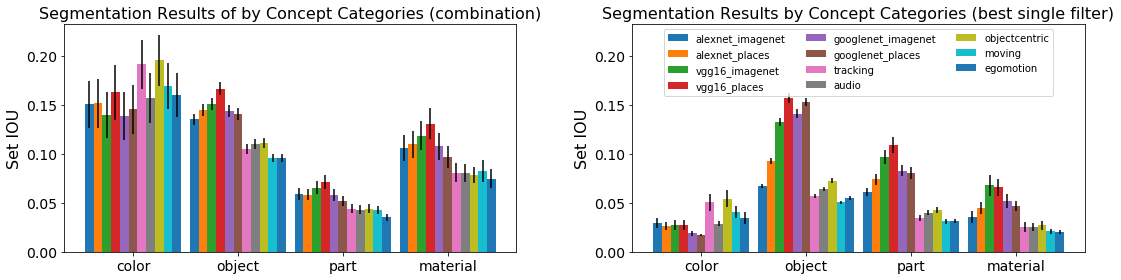

In [374]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

cat_idx = range(4)

idx = np.arange(len(cat_idx))
width = 1/float(len(seg_results)+1)
counts = np.array([np.sum(pc == i) for i in cat_idx])

j = 0
for res in seg_results:
    dist_mus = np.array([np.mean([res['linear_set_ious'][res['blobs'][-1]][pc == i]]) for i in cat_idx])
    dist_sigmas = np.array([np.std([res['linear_set_ious'][res['blobs'][-1]][pc == i]]) for i in cat_idx])
    ax[0].bar(idx + j*width, dist_mus, width, yerr=np.true_divide(dist_sigmas, np.sqrt(counts)), label=network_names[j])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[0].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
ax[0].set_ylabel('Set IOU')
ax[0].set_title('Segmentation Results of by Concept Categories (combination)')
ax[0].set_xticks(idx+width*(len(seg_results)-1)/2.)
ax[0].set_xticklabels(categories[cat_idx])
#plt.show()

new_cat_idx = range(4)
new_idx = np.arange(len(new_cat_idx))
new_counts = np.array([np.sum(pc == i) for i in new_cat_idx])

j = 0
for res in seg_results:
    best_filters = np.argmax(res['single_set_train_ious'][res['blobs'][-1]], axis=1)
    best_single_ious = np.array([res['single_set_train_ious'][res['blobs'][-1]][i,best_filters[i]]
                  for i in range(L)])
    single_mus = np.array([np.mean([x for x in best_single_ious[pc == i] if not np.isnan(x)]) for i in new_cat_idx])
    single_sigmas = np.array([np.std([x for x in best_single_ious[pc == i] if not np.isnan(x)]) for i in new_cat_idx])
    ax[1].bar(new_idx + j*width, single_mus, width, yerr=np.true_divide(single_sigmas, np.sqrt(new_counts)), label=network_names[j])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[1].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
ax[1].legend(loc='upper center', ncol=3, fontsize='10')

ax[1].set_ylabel('Set IOU')
ax[1].set_title('Segmentation Results by Concept Categories (best single filter)')
#ax[1].set_yticks(ax[0].get_yticks())
ax[1].set_xticks(new_idx+width*(len(seg_results)-1)/2.)
ax[1].set_xticklabels(categories[new_cat_idx])

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

#plt.ylim([0.5,1.0])
#formatter = FuncFormatter(to_percent)
#plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

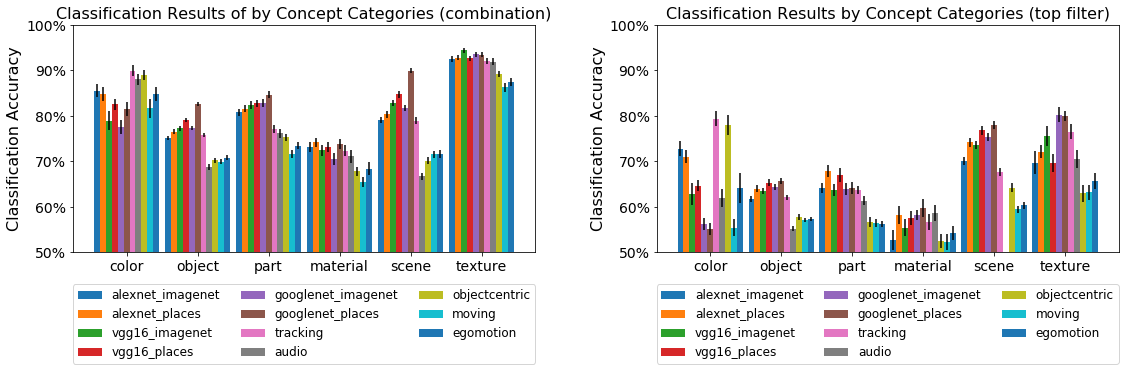

In [325]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

cat_idx = range(6)

idx = np.arange(len(cat_idx))
width = 1/float(len(class_results)+1)
counts = np.array([np.sum(pc == i) for i in cat_idx])

j = 0
for res in class_results:
    lasts = res['disc_results'][res['blobs'][-1]][:,-1,-1,-1]
    dist_mus = np.array([np.mean([x for x in lasts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    dist_sigmas = np.array([np.std([x for x in lasts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    ax[0].bar(idx + j*width, dist_mus, width, yerr=np.true_divide(dist_sigmas, np.sqrt(counts)), label=network_names[j])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[0].legend(loc='lower right')
ax[0].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')
ax[0].set_ylabel('Classification Accuracy')
ax[0].set_title('Classification Results of by Concept Categories (combination)')
ax[0].set_xticks(idx+width*(len(class_results)-1)/2.)
ax[0].set_xticklabels(categories[cat_idx])
#plt.show()

j = 0
for res in class_results:
    firsts = res['disc_results'][res['blobs'][-1]][:,0,-1,-1]
    single_mus = np.array([np.mean([x for x in firsts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    single_sigmas = np.array([np.std([x for x in firsts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    ax[1].bar(idx + j*width, single_mus, width, yerr=np.true_divide(single_sigmas, np.sqrt(counts)), label=network_names[j])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[1].legend(bbox_to_anchor=(0., 1.02, 1., 0.102), loc=3, ncol=3, borderaxespad=0., mode='expand')
ax[1].legend(bbox_to_anchor=(0., -0.07, 1., -0.07), loc=2, ncol=3, borderaxespad=0., mode='expand', fontsize='12')

ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Classification Results by Concept Categories (top filter)')
#ax[1].set_yticks(ax[0].get_yticks())
ax[1].set_xticks(idx+width*(len(class_results)-1)/2.)
ax[1].set_xticklabels(categories[cat_idx])

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

plt.ylim([0.5,1.0])
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

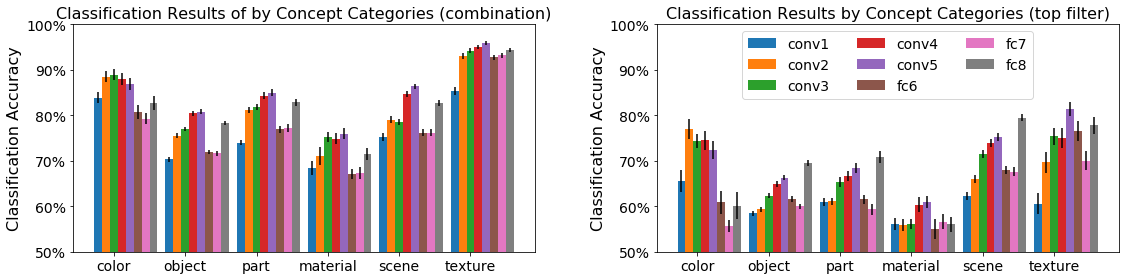

In [61]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

cat_idx = range(6)

blobs = alexnet_class_results['blobs']
idx = np.arange(len(cat_idx))
width = 1/float(len(alexnet_class_fc_results['blobs'])+1)
counts = np.array([np.sum(pc == i) for i in cat_idx])

blob_names = {'features.1': 'conv1', 'features.4': 'conv2', 'features.7': 'conv3', 'features.9': 'conv4', 
              'features.11': 'conv5', 'classifier.2': 'fc6', 'classifier.5': 'fc7', 'classifier.6': 'fc8'}

j = 0
for blob in alexnet_class_fc_results['blobs']:
    lasts = alexnet_class_fc_results['disc_results'][blob][:,-1,-1,-1]
    dist_mus = np.array([np.mean([x for x in lasts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    dist_sigmas = np.array([np.std([x for x in lasts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    ax[0].bar(idx + j*width, dist_mus, width, yerr=np.true_divide(dist_sigmas, np.sqrt(counts)), label=blob_names[blob])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
#ax[0].legend(loc='lower right')
ax[0].set_ylabel('Classification Accuracy')
ax[0].set_title('Classification Results of by Concept Categories (combination)')
ax[0].set_xticks(idx+width*(len(blobs)-1)/2.)
ax[0].set_xticklabels(categories[cat_idx])
#plt.show()

j = 0
for blob in alexnet_class_fc_results['blobs']:
    firsts = alexnet_class_fc_results['disc_results'][blob][:,0,-1,-1]
    single_mus = np.array([np.mean([x for x in firsts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    single_sigmas = np.array([np.std([x for x in firsts[pc == i] if not np.isnan(x)]) for i in cat_idx])
    ax[1].bar(idx + j*width, single_mus, width, yerr=np.true_divide(single_sigmas, np.sqrt(counts)), label=blob_names[blob])
    j += 1
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
ax[1].legend(loc='upper center', ncol=3)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Classification Results by Concept Categories (top filter)')
#ax[1].set_yticks(ax[0].get_yticks())
ax[1].set_xticks(idx+width*(len(blobs)-1)/2.)
ax[1].set_xticklabels(categories[cat_idx])

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

plt.ylim([0.5,1.0])
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

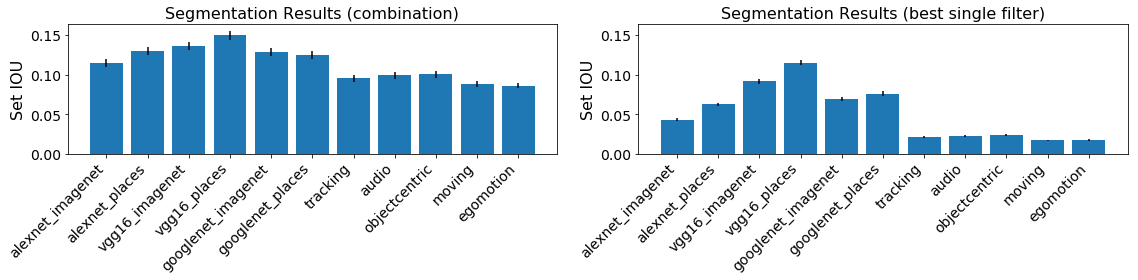

In [62]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

seg_idx = np.array([i for i in range(L) if pc[i] < 4 and pc[i] >= 0])
num_seg = len(seg_results)

mus = np.zeros(num_seg)
sigmas = np.zeros(num_seg)
for i in range(num_seg):
    mus[i] = np.mean(seg_results[i]['linear_set_ious'][seg_results[i]['blobs'][-1]][seg_idx])
    sigmas[i] = np.std(seg_results[i]['linear_set_ious'][seg_results[i]['blobs'][-1]][seg_idx])/np.sqrt(len(seg_idx))
ax[0].bar(np.arange(num_seg), mus, yerr=sigmas)
ax[0].set_ylabel('Set IOU')
ax[0].set_title('Segmentation Results (combination)')
plt.sca(ax[0])
plt.xticks(np.arange(num_seg), network_names, rotation=45, horizontalalignment='right')

mus = np.zeros(num_seg)
sigmas = np.zeros(num_seg)
for i in range(num_seg):
    best_filters = np.argmax(seg_results[i]['single_set_train_ious'][seg_results[i]['blobs'][-1]][seg_idx], axis=1)
    best_single_set_ious = np.array([seg_results[i]['single_set_val_ious'][seg_results[i]['blobs'][-1]][seg_idx[j]][best_filters[j]] 
                  for j in range(len(seg_idx))])
    #best_filters = np.argmax(seg_results[i]['single_set_train_ious'][seg_results[i]['blobs'][-1]], axis=1)
    #best_single_set_ious = np.array([seg_results[i]['single_set_val_ious'][seg_results[i]['blobs'][-1]][j,best_filters[j]] 
    #              for j in range(L)])
    mus[i] = np.mean(best_single_set_ious)
    sigmas[i] = np.std(best_single_set_ious)/np.sqrt(L)
ax[1].bar(np.arange(num_seg), mus, yerr=sigmas)
ax[1].set_ylabel('Set IOU')
ax[1].set_title('Segmentation Results (best single filter)')

plt.sca(ax[1])
plt.xticks(np.arange(num_seg), network_names, rotation=45, horizontalalignment='right')

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

#plt.ylim([0.5,1.0])
#formatter = FuncFormatter(to_percent)
#plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.show()

alexnet_imagenet 528
alexnet_places 555
vgg16_imagenet 588
vgg16_places 610
googlenet_imagenet 521
googlenet_places 514
tracking 391
audio 430
objectcentric 394
moving 376
egomotion 382


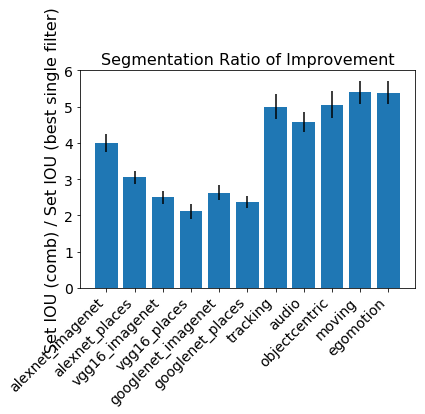

In [63]:
f, ax = plt.subplots(1,1)
mus = np.zeros(num_seg)
sigmas = np.zeros(num_seg)
for i in range(num_seg):
    comb_ious = seg_results[i]['linear_set_ious'][seg_results[i]['blobs'][-1]]
    best_filters = np.argmax(seg_results[i]['single_set_train_ious'][seg_results[i]['blobs'][-1]], axis=1)
    best_single_set_ious = np.array([seg_results[i]['single_set_val_ious'][seg_results[i]['blobs'][-1]][j,best_filters[j]] 
                  for j in range(L)])
    nzs = np.array([j for j in range(L) if best_single_set_ious[j] > 0.005 and j in seg_idx ])
    #rel_ious = np.true_divide(comb_ious - best_single_set_ious, best_single_set_ious + 1e-20)
    rel_ious = np.true_divide(comb_ious, best_single_set_ious + 1e-20)
    mus[i] = np.mean(rel_ious[nzs])
    sigmas[i] = np.std(rel_ious[nzs])/np.sqrt(len(nzs))
    print network_names[i], len(nzs)
ax.bar(np.arange(num_seg), mus, yerr=sigmas)
ax.set_ylabel('Set IOU (comb) / Set IOU (best single filter)')
ax.set_title('Segmentation Ratio of Improvement')
plt.xticks(np.arange(num_seg), network_names, rotation=45, horizontalalignment='right')
plt.show()

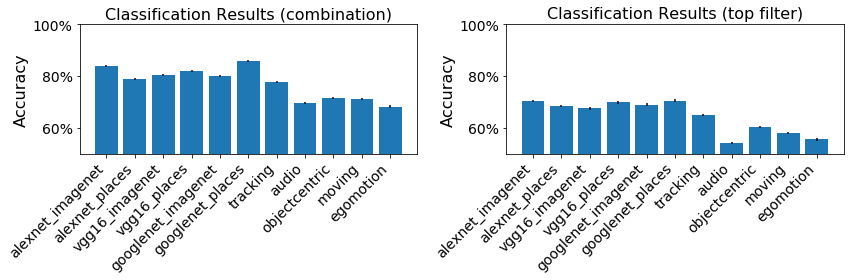

In [64]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))

num_class = len(class_results)

mus = np.zeros(num_class)
sigmas = np.zeros(num_class)
for i in range(num_class):
    mus[i] = np.mean(np.array([x for x in class_results[i]['disc_results'][class_results[i]['blobs'][-1]][:,-1,-1,-1] if not np.isnan(x)]))
    sigmas[i] = np.std(np.array([x for x in class_results[i]['disc_results'][
        class_results[i]['blobs'][-1]][:,-1,-1,-1] if not np.isnan(x)]))/np.sqrt(L)
ax[0].bar(np.arange(num_class), mus, yerr=sigmas)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Classification Results (combination)')
plt.sca(ax[0])
plt.xticks(np.arange(num_class), network_names, rotation=45, horizontalalignment='right')

mus = np.zeros(num_class)
sigmas = np.zeros(num_class)
for i in range(num_class):
    mus[i] = np.mean(np.array([x for x in class_results[i]['disc_results'][
        class_results[i]['blobs'][-1]][:,0,-1,-1] if not np.isnan(x)]))
    sigmas[i] = np.std(np.array([x for x in class_results[i]['disc_results'][
        class_results[i]['blobs'][-1]][:,0,-1,-1] if not np.isnan(x)]))/np.sqrt(L)
ax[1].bar(np.arange(num_seg), mus, yerr=sigmas)
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Classification Results (top filter)')

plt.sca(ax[1])
plt.xticks(np.arange(num_class), network_names, rotation=45, horizontalalignment='right')

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

plt.ylim([0.5,1.0])
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.show()

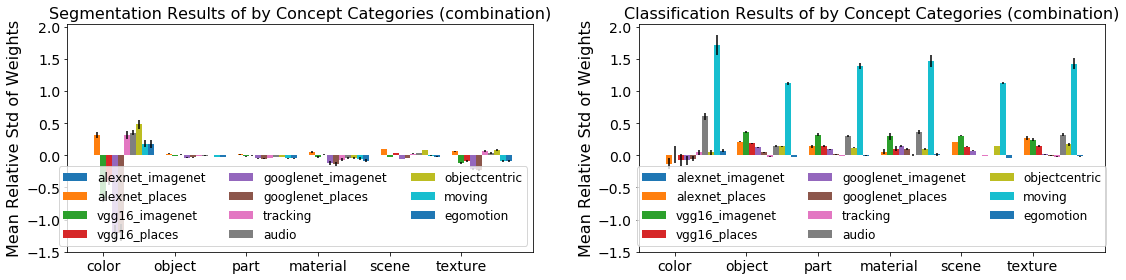

In [68]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(16,4))

cat_idx = range(6)

idx = np.arange(len(cat_idx))
width = 1/float(len(seg_results)+1)
counts = np.array([np.sum(pc == i) for i in cat_idx])

base_std = np.std(seg_results[0]['weights'][seg_results[0]['blobs'][-1]], axis=1)
other_std = np.array([np.std(seg_results[i]['weights'][seg_results[i]['blobs'][-1]], axis=1) for i in range(0, len(seg_results))])
rel_std = other_std - base_std[np.newaxis,:]

dist_mus = np.array([np.mean(rel_std[:,pc == i], axis=1) for i in cat_idx])
dist_sigmas = np.array([np.std(rel_std[:,pc == i], axis=1) for i in cat_idx])

for j in range(len(seg_results)):
    ax[0].bar(idx + j*width, dist_mus[:,j], width, yerr=np.true_divide(dist_sigmas[:,j], np.sqrt(counts)), label=network_names[j])
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
ax[0].legend(loc='lower right', ncol=3, fontsize='12')
ax[0].set_ylabel('Mean Relative Std of Weights')
ax[0].set_title('Segmentation Results of by Concept Categories (combination)')
ax[0].set_xticks(idx+width*(len(blobs)-1)/2.)
ax[0].set_xticklabels(categories[cat_idx])
#plt.show()

base_std = np.std(class_results[0]['disc_weights'][class_results[0]['blobs'][-1]][:,-1,:], axis=1)
other_std = np.array([np.std(class_results[i]['disc_weights'][class_results[i]['blobs'][-1]][:,-1,:], axis=1) for i in range(0, len(class_results))])
rel_std = other_std - base_std[np.newaxis,:]

dist_mus = np.array([np.mean(rel_std[:,pc == i], axis=1) for i in cat_idx])
dist_sigmas = np.array([np.std(rel_std[:,pc == i], axis=1) for i in cat_idx])

for j in range(len(class_results)):
    ax[1].bar(idx + j*width, dist_mus[:,j], width, yerr=np.true_divide(dist_sigmas[:,j], np.sqrt(counts)), label=network_names[j])
#ax.bar(idx+width, mus_single, width, yerr=np.true_divide(sigmas_single, np.sqrt(counts)), label='best filter')
ax[1].legend(loc='lower center', ncol=3, fontsize='12')
ax[1].set_ylabel('Mean Relative Std of Weights')
ax[1].set_title('Classification Results of by Concept Categories (combination)')
ax[1].set_xticks(idx+width*(len(blobs)-1)/2.)
ax[1].set_xticklabels(categories[cat_idx])

plt.setp(ax[0].get_yticklabels(), visible=True)
plt.setp(ax[1].get_yticklabels(), visible=True)

#plt.ylim([0.5,1.0])
#formatter = FuncFormatter(to_percent)
#plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

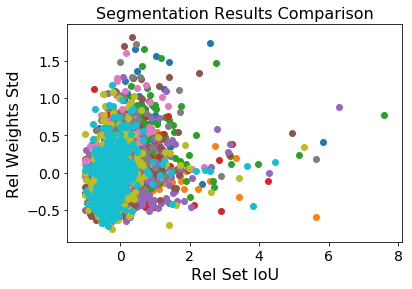

In [69]:

base_ious = seg_results[0]['linear_set_ious'][seg_results[0]['blobs'][-1]]
other_ious = np.array([seg_results[i]['linear_set_ious'][seg_results[i]['blobs'][-1]] for i in range(0, len(seg_results))])
rel_ious = np.true_divide(other_ious - base_ious[np.newaxis,:] + 1e-20, base_ious[np.newaxis,:] + 1e-20)

base_std = np.std(seg_results[0]['weights'][seg_results[0]['blobs'][-1]], axis=1)
other_std = np.array([np.std(seg_results[i]['weights'][seg_results[i]['blobs'][-1]], axis=1) for i in range(0, len(seg_results))])
rel_std = np.true_divide(other_std - base_std[np.newaxis,:] + 1e-20, base_std[np.newaxis,:] + 1e-20)

f, ax = plt.subplots(1,1)

for i in range(1, len(seg_results)):
    idx = np.where(base_ious[seg_idx] > 0.005)[0]
    ax.scatter(rel_ious[i][seg_idx[idx]], rel_std[i][seg_idx[idx]])

ax.set_xlabel('Rel Set IoU')
ax.set_ylabel('Rel Weights Std')
ax.set_title('Segmentation Results Comparison')
plt.show()

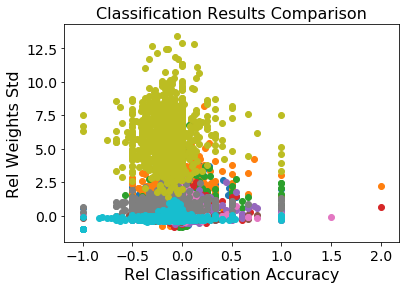

In [70]:
base_ious = class_results[0]['disc_results'][class_results[0]['blobs'][-1]][:,-1,-1,-1]
other_ious = np.array([class_results[i]['disc_results'][class_results[i]['blobs'][-1]][:,-1,-1,-1] for i in range(0, len(seg_results))])
#rel_ious = other_ious - base_ious[np.newaxis,:]
rel_ious = np.true_divide(other_ious - base_ious[np.newaxis,:] + 1e-20, base_ious[np.newaxis,:] + 1e-20)

base_std = np.std(class_results[0]['disc_weights'][class_results[0]['blobs'][-1]][:,-1,:], axis=1)
other_std = np.array([np.std(class_results[i]['disc_weights'][class_results[i]['blobs'][-1]][:,-1,:], axis=1) for i in range(0, len(class_results))])
#rel_std = other_std - base_std[np.newaxis,:]
rel_std = np.true_divide(other_std - base_std[np.newaxis,:] + 1e-20, base_std[np.newaxis,:] + 1e-20)

f, ax = plt.subplots(1,1)

for i in range(1, len(class_results)):
    idx = np.where(base_ious > 0.005)[0]
    ax.scatter(rel_ious[i][idx], rel_std[i][idx])

ax.set_xlabel('Rel Classification Accuracy')
ax.set_ylabel('Rel Weights Std')
ax.set_title('Classification Results Comparison')
plt.show()

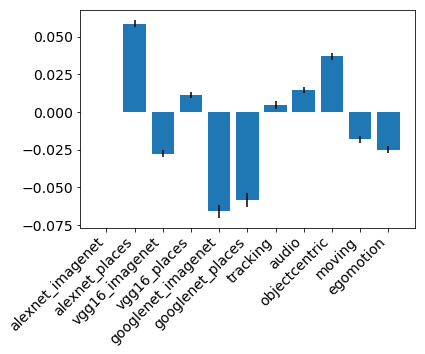

In [74]:
# idx == np.where(pc == 0)[0]

base_std = np.std(seg_results[0]['weights'][seg_results[0]['blobs'][-1]][idx], axis=1)
other_std = np.array([np.std(seg_results[i]['weights'][seg_results[i]['blobs'][-1]][idx], axis=1) for i in range(0, len(seg_results))])
rel_std = other_std - base_std[np.newaxis,:]

f, ax = plt.subplots(1,1)

ax.bar(np.arange(len(seg_results)), np.mean(rel_std, axis=1), yerr=np.std(rel_std, axis=1)/np.sqrt(len(idx)))
plt.xticks(np.arange(len(seg_results)), network_names, rotation=45, horizontalalignment='right')

plt.show()

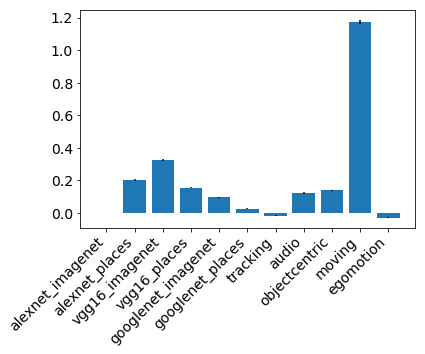

In [73]:
base_std = np.std(class_results[0]['disc_weights'][class_results[0]['blobs'][-1]][:,-1,:], axis=1)
other_std = np.array([np.std(class_results[i]['disc_weights'][class_results[i]['blobs'][-1]][:,-1,:], axis=1) for i in range(0, len(class_results))])
rel_std = other_std - base_std[np.newaxis,:]

f, ax = plt.subplots(1,1)

ax.bar(np.arange(len(class_results)), np.mean(rel_std, axis=1), yerr=np.std(rel_std, axis=1)/np.sqrt(L))
plt.xticks(np.arange(len(class_results)), network_names, rotation=45, horizontalalignment='right')

plt.show()

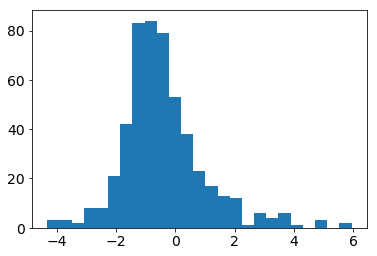

In [225]:
f, ax = plt.subplots(1,1)
ax.hist(vgg_seg_results['weights']['conv5_3'][19,:], bins=25)
plt.show()

In [226]:
vgg_class_results['disc_weights']['conv5_3'].shape

(1198, 2, 512)

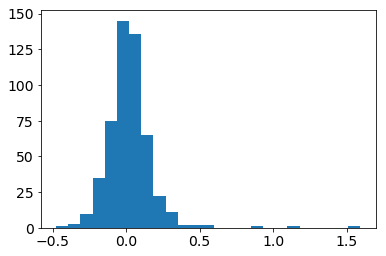

In [230]:
f, ax = plt.subplots(1,1)
ax.hist(vgg_class_results['disc_weights']['conv5_3'][10,-1,:], bins=25)
plt.show()

# Net2Vec (Word Embeddings)

In [54]:
def load_wv(results, blob=None):
    is_seg = True if 'weights' in results else False
    if blob is None:
        blob = results['blobs'][-1]
    if is_seg:
        weights = results['weights'][blob]
        idx = seg_idx
    else:
        weights = results['disc_weights'][blob][:,-1,:]
        idx = range(1, L)
    norm_weights = np.array([np.true_divide(weights[i], np.linalg.norm(weights[i])) for i in idx])
    wv_res = WordVectors(vocab=label_names[idx], vectors=np.copy(norm_weights)) 
    return wv_res

In [770]:
def compute_wv_similarity(wv1, wv2, wv1_idx=None, wv2_idx=None):
    if wv1_idx is None:
        d1 = np.dot(wv1.vectors, wv1.vectors.T)
    else:
        d1 = np.dot(wv1.vectors[wv1_idx,:], wv1.vectors[wv1_idx,:].T)
    if wv2_idx is None:
        d2 = np.dot(wv2.vectors, wv2.vectors.T)
    else:
        d2 = np.dot(wv2.vectors[wv2_idx,:], wv2.vectors[wv2_idx,:].T)
    assert(d1.shape == d2.shape)
    #example_dists = np.array([np.linalg.norm(d1[i]-d2[i])**2 for i in range(d1.shape[0])])
    example_dists = np.array([np.linalg.norm(d1[i]-d2[i])**2 for i in range(d1.shape[0])])
    all_dist = np.linalg.norm(d1-d2)**2#/np.prod(d1.shape)
    return (all_dist, example_dists)

In [303]:
def sort_concepts(wv):
    d = np.dot(wv.vectors, wv.vectors.T)
    np.fill_diagonal(d, 0)
    sorted_idx_by_max = np.argsort(np.max(np.abs(d), axis=1))
    sorted_idx_by_mean = np.argsort(np.mean(np.abs(d), axis=1))
    return (sorted_idx, sorted_idx_2)

In [304]:
def list_nearest_neighbors(wv, idx, n=5):
    for i in range(n):
        indexes, metrics = wv.cosine(wv.vocab[idx[i]], n=1)
        print wv.vocab[idx[i]], wv.vocab[indexes[0]], metrics[0] 

In [305]:
def list_k_nearest_neighbors(wv, word, n=5):
    indexes, metrics = wv.cosine(word, n=n)
    for i in range(n):
        print word, wv.vocab[indexes[i]], metrics[i] 

In [448]:
import nltk
from nltk.corpus import wordnet as wn
nltk.data.path.append('/scratch/shared/slow/ruthfong/nltk_data')

In [456]:
hyp = lambda s: s.hypernyms()

In [610]:
broden_in_wn_idx = []
synsets = []
for i in range(1,L):
    if len(wn.synsets(esc_label_names[i])) > 0:
        s = wn.synsets(esc_label_names[i])[0]
        synsets.append(s)
        broden_in_wn_idx.append(i)

In [611]:
synset_replacements = {1: 'gray.n.01', 2: 'white.n.02', 10: 'orange.n.02', 66: 'muzzle.n.02', 152: 'bannister.n.02', 
                      226: 'blotchy.s.02', 294: 'bumpy.s.02', 310: 'porous.a.02', 320: 'meshed.s.01', 
                      372: 'crane.n.04', 487: 'jersey.n.04'}
remove_synsets = [355] # waffled

In [612]:
for i in synset_replacements.keys():
    synsets[i] = wn.synset(synset_replacements[i])

In [613]:
for i in remove_synsets:
    del synsets[i]
    del broden_in_wn_idx[i]

In [614]:
synsets = np.array(synsets)
broden_in_wn_idx = np.array(broden_in_wn_idx)

In [615]:
offsets = []
names = []

for s in synsets:
    x = list(s.closure(hyp))
    x.insert(0,s)
    offsets.append([y.offset() for y in x])
    names.append([y.name() for y in x])

In [616]:
l = np.array([len(x) for x in offsets])

In [617]:
all_unique_offsets = np.unique([item for sublist in offsets for item in sublist])

In [618]:
offset_hash = {}
for i in range(len(all_unique_offsets)):
    offset_hash[all_unique_offsets[i]] = i

In [619]:
assert(len(synsets) == len(names))

In [620]:
wn_weights = np.zeros((len(synsets), len(all_unique_offsets)))

for i in range(len(synsets)):
    idx = [offset_hash[j] for j in offsets[i]]
    wn_weights[i,idx] = 1

In [621]:
norm_weights = np.array([np.true_divide(wn_weights[i], np.linalg.norm(wn_weights[i])) for i in range(len(synsets))])
wn_wv = WordVectors(vocab=label_names[broden_in_wn_idx], vectors=np.copy(norm_weights)) 

In [673]:
wn_wv.vectors.shape

(937, 1664)

In [513]:
def print_all_synset_definitions(word):
    for s in wn.synsets(word):
        print s.name(), s.definition()

In [546]:
for i in range(60,70):
    print i, names[i][0], synsets[i].definition()

60 bed.n.01 a piece of furniture that provides a place to sleep
61 eyebrow.n.01 the arch of hair above each eye
62 sofa.n.01 an upholstered seat for more than one person
63 handle.n.01 the appendage to an object that is designed to be held in order to use or move it
64 box.n.01 a (usually rectangular) container; may have a lid
65 tail.n.01 the posterior part of the body of a vertebrate especially when elongated and extending beyond the trunk or main part of the body
66 gun_muzzle.n.01 the open circular discharging end of a gun
67 earth.n.01 the 3rd planet from the sun; the planet we live on
68 bottle.n.01 a glass or plastic vessel used for storing drinks or other liquids; typically cylindrical without handles and with a narrow neck that can be plugged or capped
69 paper.n.01 a material made of cellulose pulp derived mainly from wood or rags or certain grasses


In [554]:
np.where(l == 1)

(array([ 67, 152, 226, 294, 310, 312, 320, 333, 337, 348, 352, 355, 363,
        364, 372, 487, 715, 770]),)

In [577]:
list(wn.synset('scaly.s.02').closure(hyp))

[]

In [585]:
x = label_names[broden_in_wn_idx[770]]
print x
print_all_synset_definitions('islet')

medina-s
isle.n.01 a small island


In [383]:
w2v = word2vec.load('../dataset/word2vec/text8.bin')

In [392]:
esc_label_names = np.array([l.split('-c')[0].split('-s')[0].replace(' ', '_') for l in label_names])

In [400]:
broden_in_w2v_idx = []
w2v_broden_idx = []
for i in range(1,L):
    if esc_label_names[i] in w2v.vocab_hash:
        broden_in_w2v_idx.append(i)
        w2v_broden_idx.append(w2v.vocab_hash[esc_label_names[i]])
broden_in_w2v_idx = np.array(broden_in_w2v_idx)
w2v_broden_idx = np.array(w2v_broden_idx)

In [746]:
from functools import reduce

In [748]:
min_idx = reduce(np.intersect1d, (range(1,L), seg_idx, broden_in_w2v_idx, broden_in_wn_idx))

In [749]:
len(min_idx)

501

In [326]:
alexnet_seg_wv = load_wv(alexnet_seg_results)
caffe_seg_wv = load_wv(caffe_seg_results)
caffep_seg_wv = load_wv(caffep_seg_results)
vgg_seg_wv = load_wv(vgg_seg_results)
vggp_seg_wv = load_wv(vggp_seg_results)
googlenet_seg_wv = load_wv(googlenet_seg_results)
googlenetp_seg_wv = load_wv(googlenetp_seg_results)

tracking_seg_wv = load_wv(tracking_seg_results)
audio_seg_wv = load_wv(audio_seg_results)
objectcentric_seg_wv = load_wv(objectcentric_seg_results)
moving_seg_wv = load_wv(moving_seg_results)
egomotion_seg_wv = load_wv(egomotion_seg_results)

In [327]:
alexnet_class_wv = load_wv(alexnet_class_results)
caffe_class_wv = load_wv(caffe_class_results)
caffep_class_wv = load_wv(caffep_class_results)
vgg_class_wv = load_wv(vgg_class_results)
vggp_class_wv = load_wv(vggp_class_results)
googlenet_class_wv = load_wv(googlenet_class_results)
googlenetp_class_wv = load_wv(googlenetp_class_results)

tracking_class_wv = load_wv(tracking_class_results)
audio_class_wv = load_wv(audio_class_results)
objectcentric_class_wv = load_wv(objectcentric_class_results)
moving_class_wv = load_wv(moving_class_results)
egomotion_class_wv = load_wv(egomotion_class_results)

In [328]:
seg_wvs = [caffe_seg_wv, caffep_seg_wv, vgg_seg_wv, vggp_seg_wv, googlenet_seg_wv, googlenetp_seg_wv, 
          tracking_seg_wv, audio_seg_wv, objectcentric_seg_wv, moving_seg_wv, egomotion_seg_wv]
class_wvs = [caffe_class_wv, caffep_class_wv, vgg_class_wv, vggp_class_wv, googlenet_class_wv, googlenetp_class_wv, 
          tracking_class_wv, audio_class_wv, objectcentric_class_wv, moving_class_wv, egomotion_class_wv]

In [695]:
all_wvs = []
all_wvs.extend(seg_wvs)
all_wvs.extend(class_wvs)
all_wvs.append(wn_wv)
all_wvs.append(w2v)

In [756]:
def get_wv_idx(wv_i):
    if wv_i < (len(all_wvs)-2)/2: # segmentation
        wv_idx = [i for i in range(len(seg_idx)) if seg_idx[i] in min_idx]
    elif wv_i < len(all_wvs)-2: # classification
        wv_idx = min_idx-1
    elif wv_i == len(all_wvs)-2: # wordnet
        wv_idx = [i for i in range(len(broden_in_wn_idx)) if broden_in_wn_idx[i] in min_idx]
    elif wv_i == len(all_wvs)-1: # word2vec
        wv_idx = [w2v_broden_idx[i] for i in range(len(broden_in_w2v_idx)) if broden_in_w2v_idx[i] in min_idx]
    else:
        assert(False)
    return wv_idx

In [767]:
dists_btwn_wvs = np.zeros((len(all_wvs), len(all_wvs)))
example_dists_btwn_wvs = np.zeros((len(all_wvs), len(all_wvs), L))

for i in range(len(all_wvs)):
    for j in range(len(all_wvs)):
        wv1_idx = get_wv_idx(i)
        wv2_idx = get_wv_idx(j)
        (net_dist, example_dists) = compute_wv_similarity(all_wvs[i], all_wvs[j], wv1_idx, wv2_idx)
        dists_btwn_wvs[i,j] = net_dist
        example_dists_btwn_wvs[i,j,min_idx] = example_dists

In [696]:
dists_btwn_wvs = np.zeros((len(all_wvs), len(all_wvs)))
example_dists_btwn_wvs = np.zeros((len(all_wvs), len(all_wvs), L))

for i in range(len(all_wvs)):
    for j in range(len(all_wvs)):
        if i < (len(all_wvs)-2)/2:
            wv1_idx = 
        wv1_idx = None if i < (len(all_wvs)-2)/2 else seg_idx-1
        wv2_idx = None if j < (len(all_wvs)-2)/2 else seg_idx-1
        if i >= (len(all_wvs)-2)/2 and j >= (len(all_wvs)-2)/2:
            wv1_idx = None
            wv2_idx = None
        (net_dist, example_dists) = compute_wv_similarity(all_wvs[i], all_wvs[j], wv1_idx, wv2_idx)
        dists_btwn_wvs[i,j] = net_dist
        if all_wvs[i].vectors.shape[0] == L-1 and all_wvs[j].vectors.shape[0] == L-1:
            example_dists_btwn_wvs[i,j,1:] = example_dists
        else:
            example_dists_btwn_wvs[i,j,seg_idx] = example_dists

In [650]:
seg_in_wn_idx = np.array([i for i in range(len(seg_idx)) if seg_idx[i] in broden_in_wn_idx])
wn_seg_idx = np.array([i for i in range(len(broden_in_wn_idx)) if broden_in_wn_idx[i] in seg_idx])

In [698]:
for i in range(len(all_wvs)-2):
    wv1_idx = seg_in_wn_idx if i < (len(all_wvs)-2)/2 else broden_in_wn_idx-1
    wv2_idx = wn_seg_idx if i < (len(all_wvs)-2)/2 else range(len(broden_in_wn_idx))
    (net_dist, example_dists) = compute_wv_similarity(all_wvs[i], wn_wv, wv1_idx, wv2_idx)
    dists_btwn_wvs[-2,i] = net_dist
    dists_btwn_wvs[i,-2] = net_dist
    if i < (len(all_wvs)-2)/2:
        example_dists_btwn_wvs[i,-2,seg_idx[seg_in_wn_idx]] = example_dists
    else:
        example_dists_btwn_wvs[i,-2,broden_in_wn_idx] = example_dists
    example_dists_btwn_wvs[-2,i,:] = example_dists_btwn_wvs[i,-2]

In [699]:
seg_in_w2v_idx = np.array([i for i in range(len(seg_idx)) if seg_idx[i] in broden_in_w2v_idx])
w2v_seg_idx = np.array([w2v_broden_idx[i] for i in range(len(broden_in_w2v_idx)) if broden_in_w2v_idx[i] in seg_idx])

In [700]:
for i in range(len(all_wvs)-2):
    wv1_idx = seg_in_w2v_idx if i < (len(all_wvs)-2)/2 else broden_in_w2v_idx-1
    wv2_idx = w2v_seg_idx if i < (len(all_wvs)-2)/2 else w2v_broden_idx
    (net_dist, example_dists) = compute_wv_similarity(all_wvs[i], w2v, wv1_idx, wv2_idx)
    dists_btwn_wvs[-1,i] = net_dist
    dists_btwn_wvs[i,-1] = net_dist
    if i < (len(all_wvs)-2)/2:
        example_dists_btwn_wvs[i,-1,seg_idx[seg_in_w2v_idx]] = example_dists
    else:
        example_dists_btwn_wvs[i,-1,broden_in_w2v_idx] = example_dists
    example_dists_btwn_wvs[-1,i,:] = example_dists_btwn_wvs[i,-1]

In [701]:
broden_in_both_idx = np.intersect1d(broden_in_w2v_idx, broden_in_wn_idx)
wv1_idx = [i for i in range(len(broden_in_wn_idx)) if broden_in_wn_idx[i] in broden_in_both_idx]
wv2_idx = [w2v_broden_idx[i] for i in range(len(broden_in_w2v_idx)) if broden_in_w2v_idx[i] in broden_in_both_idx]
(net_dist, example_dists) = compute_wv_similarity(wn_wv, w2v, wv1_idx, wv2_idx)
dists_btwn_wvs[-1,-2] = net_dist
dists_btwn_wvs[-2,-1] = net_dist
example_dists_btwn_wvs[-2,-1,broden_in_both_idx] = example_dists
example_dists_btwn_wvs[-1,-2,broden_in_both_idx] = example_dists

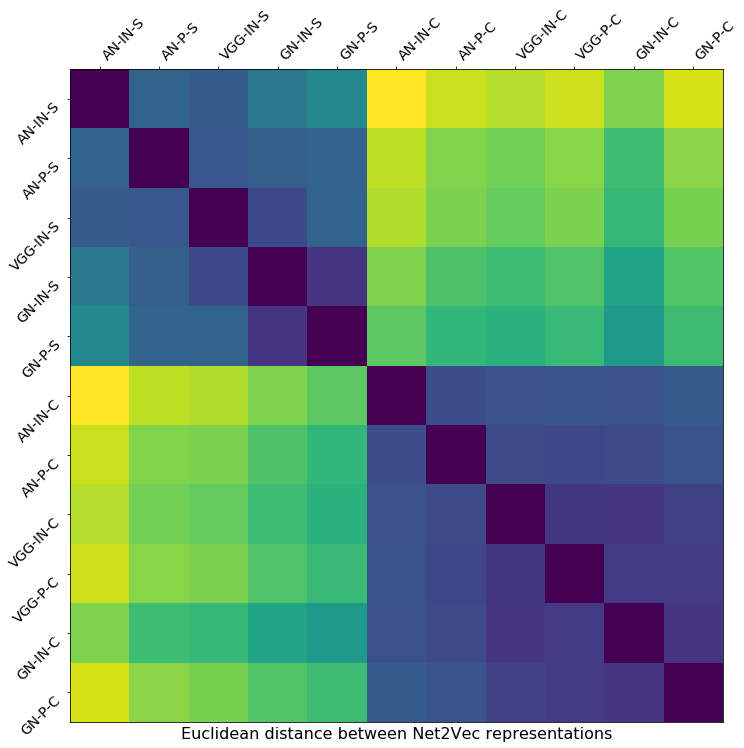

In [799]:
idx = [0,1,2,4,5,11,12,13,14,15,16]
short_network_names = ['AN-IN', 'AN-P', 'VGG-IN', 'VGG-P', 'GN-IN', 'GN-P', 'T', 'A', 'OC', 'M', 'EM']
all_names = np.concatenate((['%s-S' % x for x in short_network_names], ['%s-C' % x for x in short_network_names], 
                            ['WN', 'W2V']), axis=0)
subset = dists_btwn_wvs[idx,:]
subset = subset[:,idx]
subset_names = all_names[idx]

f, ax = plt.subplots(1,1, figsize=(12,12))
cax = ax.matshow(subset)
#f.colorbar(cax)
ax.set_xlabel('Euclidean distance between Net2Vec representations')
plt.xticks(range(len(idx)), subset_names, rotation=45, horizontalalignment='left')
plt.yticks(range(len(idx)), subset_names, rotation=45, verticalalignment='top')
plt.tick_params(
    axis='x',
    which='both',
    bottom='off')
#    top='off') 
#plt.tick_params(
#    axis='y',
#    which='both',
#    left='off',
#    right='off')
plt.show()
plt.show()

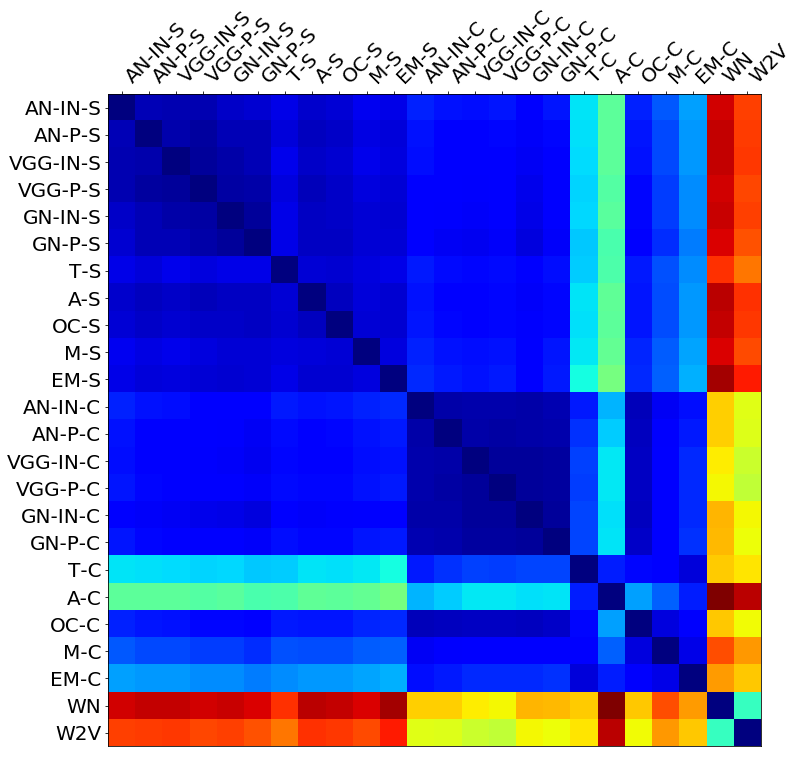

In [811]:
f, ax = plt.subplots(1,1, figsize=(12,12))
cax = ax.matshow(dists_btwn_wvs, cmap='jet')
#f.colorbar(cax)
#ax.set_xlabel('Euclidean distance between Net2Vec representations', fontsize=24)
plt.xticks(range(len(all_wvs)), all_names, rotation=45, horizontalalignment='left', fontsize=20)
plt.yticks(range(len(all_wvs)), all_names, fontsize=20)#, rotation=45, verticalalignment='top', fontsize=20)
plt.tick_params(
    axis='x',
    which='both',
    bottom='off')
#    top='off') 
#plt.tick_params(
#    axis='y',
#    which='both',
#    left='off',
#    right='off')
plt.show()
plt.show()

In [793]:
def show_dists_by_category(wv1_i, wv2_i, num_cat=6):
    mus = np.zeros(num_cat)
    sigmas = np.zeros(num_cat)
    stderr = np.zeros(num_cat)
    sel_idx = np.where(example_dists_btwn_wvs[wv1_i,wv2_i])[0]

    print '%s vs. %s (N = %d)' % (all_names[wv1_i], all_names[wv2_i], len(sel_idx))
    print '%10s\t%s\t%s\t%s\t' % ('', 'mean', 'std', r'stderr')
    for c in range(num_cat):
        dists = np.array([example_dists_btwn_wvs[wv1_i,wv2_i,i] for i in sel_idx if pc[i] == c])
        mus[c] = np.mean(dists)
        sigmas[c] = np.std(dists)
        stderr[c] = sigmas[c]/np.sqrt(len(pc[sel_idx] == c)+1e-20)
        print '%10s\t%.2f\t%.2f\t%.2f' % (categories[c], mus[c], sigmas[c], stderr[c])

In [790]:
def graph_dists_by_category(idx_pairs, num_cats=6):
    f, ax = plt.subplots(1,1, figsize=(8,8))
    
    mus = np.zeros((num_cats, len(idx_pairs)))
    Ns = np.zeros(len(idx_pairs))
    for col in range(len(idx_pairs)):
        i = idx_pairs[col][0]
        j = idx_pairs[col][1]
        sel_idx = np.where(example_dists_btwn_wvs[i,j])[0]
        Ns[col] = len(sel_idx)
        for cat in range(num_cats):
            mus[cat,col] = np.mean([example_dists_btwn_wvs[i,j,k] for k in sel_idx if pc[k] == cat])
    cax = ax.matshow(mus.T, cmap='jet')
    #f.colorbar(cax)
    pair_names = ['%s vs. %s' % (all_names[idx_pairs[col][0]], all_names[idx_pairs[col][1]]) for col in range(len(idx_pairs))]
    #pair_names = ['%s vs. %s (N = %d)' % (all_names[idx_pairs[col][0]], 
    #                                      all_names[idx_pairs[col][1]], Ns[col]) for col in range(len(idx_pairs))]
    plt.yticks(range(len(idx_pairs)), pair_names, rotation=45, verticalalignment='top')
    plt.xticks(range(num_cats), ['%s\n(N=%d)' % (categories[i], np.sum(pc[sel_idx]==i)) for i in range(num_cats)], horizontalalignment='center')
    plt.tick_params(
        axis='x',
        which='both',
        bottom='off')
    plt.tight_layout()
    plt.show()

In [728]:
def show_changed_concepts(wv1_i, wv2_i, n=5):
    sel_idx = np.where(example_dists_btwn_wvs[wv1_i, wv2_i])[0]
    sorted_idx = np.argsort(example_dists_btwn_wvs[wv1_i, wv2_i,sel_idx])
    
    print '%s vs. %s (N = %d)' % (all_names[wv1_i], all_names[wv2_i], len(sel_idx))
    print 'bottom %d:' % n
    for i in range(n):
        ind = sel_idx[sorted_idx[i]]
        print label_names[ind], categories[pc[ind]], example_dists_btwn_wvs[wv1_i, wv2_i, ind]
        
    print '\ntop %d:' % n
    for i in range(n):
        ind = sel_idx[sorted_idx[-(i+1)]]
        print label_names[ind], categories[pc[ind]], example_dists_btwn_wvs[wv1_i, wv2_i, ind]

In [711]:
wv1_i = 11
wv2_i = 23
sel_idx = np.where(example_dists_btwn_wvs[wv1_i,wv2_i])[0]
print np.mean(example_dists_btwn_wvs[wv1_i, wv2_i,sel_idx])

70.0921192564


In [729]:
show_changed_concepts(17,22)
print ''
show_changed_concepts(18,22)
print ''
show_changed_concepts(17,23)
print ''
show_changed_concepts(18,23)

tracking_class vs. wordnet (N = 937)
bottom 5:
crosshatched texture 14.0194255441
studded texture 15.0373855453
dotted texture 15.6683285556
chequered texture 15.6832695904
cracked texture 17.3891697852

top 5:
basement-s scene 320.921851899
bird feeder object 297.489221689
ceramic material 295.029504181
fabric material 291.411720069
linoleum material 289.462859923

audio_class vs. wordnet (N = 937)
bottom 5:
medina-s scene 14.6493688239
chequered texture 19.808122023
blue-c color 21.5494308502
purple-c color 22.4064750011
white-c color 22.8678269276

top 5:
ceramic material 418.553633836
fabric material 387.483007852
attic-s scene 385.421982031
laminate material 370.335675486
basement-s scene 360.105874482

tracking_class vs. word2vec (N = 686)
bottom 5:
can object 20.8715785318
house object 22.7047504668
poster object 22.786118278
case object 22.9967814549
earth object 23.3204806705

top 5:
wrinkled texture 246.890668949
pleated texture 244.791783154
striped texture 242.395991478
per

In [730]:
show_changed_concepts(17,11)
print ''
show_changed_concepts(18,11)

tracking_class vs. alexnet_imagenet_class (N = 1197)
bottom 5:
leg part 5.2471643044
arm part 5.86063380783
metal material 6.7357402836
windowpane object 7.60673571315
floor object 7.6159602117

top 5:
wrinkled texture 80.9140719496
striped texture 78.863328219
island object 75.2852821094
hallway-s scene 70.7971699405
mosque-indoor-s scene 67.3703589889

audio_class vs. alexnet_imagenet_class (N = 1197)
bottom 5:
leg part 6.94902852154
person object 9.3400467462
arm part 9.36656336041
wall object 9.76599902273
windowpane object 10.357997283

top 5:
kettle object 121.571141288
switch object 115.479330251
refrigerator object 115.102316227
doorframe object 113.972855084
stile part 113.422634068


In [725]:
show_dists_by_category(0,23,num_cat=6)
show_dists_by_category(11,23,num_cat=6)

alexnet_imagenet_seg vs. word2vec (N = 502)
          	mean	std	stderr	
     color	67.72	20.87	0.93
    object	67.20	30.04	1.34
      part	77.07	30.51	1.36
  material	92.58	27.84	1.24
     scene	nan	nan	nan
   texture	nan	nan	nan
alexnet_imagenet_class vs. word2vec (N = 686)
          	mean	std	stderr	
     color	93.80	32.23	1.23
    object	65.92	32.12	1.23
      part	82.68	34.77	1.33
  material	95.82	33.65	1.28
     scene	65.00	26.35	1.01
   texture	93.45	26.73	1.02


In [726]:
show_dists_by_category(11,17,num_cat=6)
show_dists_by_category(11,18,num_cat=6)

alexnet_imagenet_class vs. tracking_class (N = 1197)
          	mean	std	stderr	
     color	17.04	5.32	0.15
    object	31.58	10.11	0.29
      part	27.95	11.25	0.33
  material	21.10	11.28	0.33
     scene	33.57	8.17	0.24
   texture	42.78	13.28	0.38
alexnet_imagenet_class vs. audio_class (N = 1197)
          	mean	std	stderr	
     color	28.31	9.15	0.26
    object	52.80	22.31	0.64
      part	58.12	27.92	0.81
  material	61.92	20.89	0.60
     scene	42.57	15.17	0.44
   texture	59.49	11.18	0.32


In [721]:
show_dists_by_category(17,22,num_cat=6)
show_dists_by_category(18,22,num_cat=6)
show_dists_by_category(17,23,num_cat=6)
show_dists_by_category(18,23,num_cat=6)

tracking_class vs. wordnet (N = 937)
          	mean	std	stderr	
     color	25.67	5.51	0.18
    object	122.23	53.54	1.75
      part	111.67	53.67	1.75
  material	129.12	85.01	2.78
     scene	142.79	59.65	1.95
   texture	35.23	34.83	1.14
audio_class vs. wordnet (N = 937)
          	mean	std	stderr	
     color	32.54	12.29	0.40
    object	171.15	68.48	2.24
      part	162.61	74.88	2.45
  material	199.99	101.65	3.32
     scene	189.65	69.75	2.28
   texture	56.81	46.86	1.53
tracking_class vs. word2vec (N = 686)
          	mean	std	stderr	
     color	78.88	27.24	1.04
    object	76.04	30.97	1.18
      part	92.66	35.75	1.37
  material	114.06	39.87	1.52
     scene	87.20	33.89	1.29
   texture	160.20	45.54	1.74
audio_class vs. word2vec (N = 686)
          	mean	std	stderr	
     color	80.91	26.61	1.02
    object	107.23	44.70	1.71
      part	128.86	52.74	2.01
  material	172.43	55.82	2.13
     scene	116.45	43.22	1.65
   texture	189.24	41.13	1.57


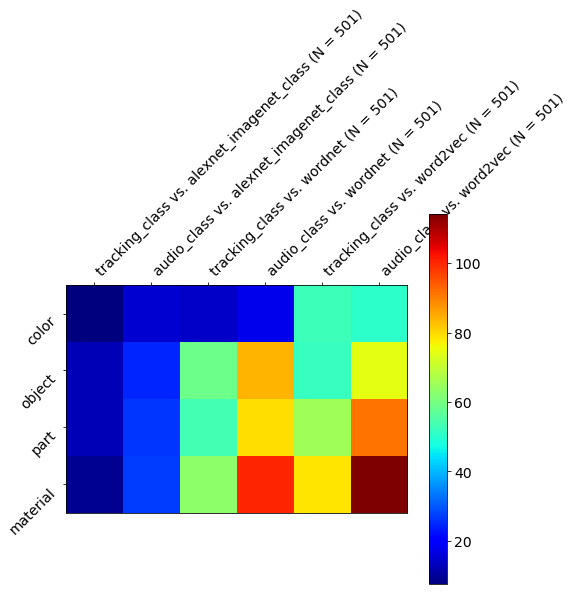

In [779]:
graph_dists_by_category([(17,11),(18,11),(17,22),(18,22),(17,23),(18,23)], num_cats=4)

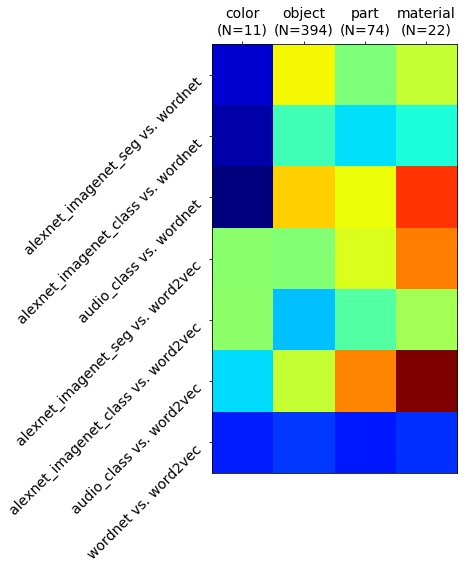

In [796]:
graph_dists_by_category([(0,22),(11,22),(18,22),(0,23),(11,23),(18,23),(22,23)], num_cats=4)

In [798]:
show_dists_by_category(0,22, num_cat=4)
show_dists_by_category(11,22, num_cat=4)
show_dists_by_category(18,22, num_cat=4)
show_dists_by_category(0,23, num_cat=4)
show_dists_by_category(11,23, num_cat=4)
show_dists_by_category(18,23, num_cat=4)
show_dists_by_category(22,23, num_cat=4)

alexnet_imagenet_seg vs. wordnet (N = 501)
          	mean	std	stderr	
     color	24.67	5.17	0.23
    object	80.26	37.49	1.67
      part	66.23	38.60	1.72
  material	74.43	49.50	2.21
alexnet_imagenet_class vs. wordnet (N = 501)
          	mean	std	stderr	
     color	21.35	3.28	0.15
    object	59.08	30.76	1.37
      part	50.94	29.86	1.33
  material	54.82	41.45	1.85
audio_class vs. wordnet (N = 501)
          	mean	std	stderr	
     color	17.62	6.61	0.30
    object	84.17	34.79	1.55
      part	79.33	35.47	1.58
  material	100.14	50.03	2.24
alexnet_imagenet_seg vs. word2vec (N = 501)
          	mean	std	stderr	
     color	67.68	20.85	0.93
    object	67.04	30.00	1.34
      part	76.91	30.41	1.36
  material	92.43	27.75	1.24
alexnet_imagenet_class vs. word2vec (N = 501)
          	mean	std	stderr	
     color	67.94	23.57	1.05
    object	48.16	23.49	1.05
      part	61.28	24.95	1.11
  material	70.49	22.37	1.00
audio_class vs. word2vec (N = 501)
          	mean	std	stderr	
     color	50.53	18.42	0.82

In [658]:
show_dists_by_category(0,1,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(2,3,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(4,5,num_cat=4,sel_idx=seg_idx)

alexnet_imagenet_seg vs. alexnet_places_seg
          	mean	std	stderr	
     color	3.7773	0.2730	0.0105
    object	5.6364	1.4283	0.0547
      part	5.8808	1.7287	0.0662
  material	4.9681	1.2259	0.0469
vgg16_imagenet_seg vs. vgg16_places_seg
          	mean	std	stderr	
     color	1.9569	0.2562	0.0098
    object	2.8265	0.5992	0.0229
      part	2.8985	0.9210	0.0353
  material	2.6312	0.7223	0.0277
googlenet_imagenet_seg vs. googlenet_places_seg
          	mean	std	stderr	
     color	1.8630	0.2204	0.0084
    object	2.6073	0.8179	0.0313
      part	2.9685	1.0816	0.0414
  material	3.2404	0.9373	0.0359


In [659]:
show_dists_by_category(0,2,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(0,4,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(2,4,num_cat=4,sel_idx=seg_idx)

alexnet_imagenet_seg vs. vgg16_imagenet_seg
          	mean	std	stderr	
     color	3.6686	0.5737	0.0220
    object	5.0858	1.0437	0.0400
      part	5.2410	1.3096	0.0501
  material	4.7446	0.9687	0.0371
alexnet_imagenet_seg vs. googlenet_imagenet_seg
          	mean	std	stderr	
     color	5.0097	0.7399	0.0283
    object	6.8310	2.3620	0.0904
      part	7.5164	2.7604	0.1057
  material	7.4993	1.8677	0.0715
vgg16_imagenet_seg vs. googlenet_imagenet_seg
          	mean	std	stderr	
     color	2.5154	0.3642	0.0139
    object	3.8058	1.1917	0.0456
      part	3.9521	1.4154	0.0542
  material	4.7101	1.4220	0.0545


In [660]:
show_dists_by_category(1,3,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(1,5,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(3,5,num_cat=4,sel_idx=seg_idx)

alexnet_places_seg vs. vgg16_places_seg
          	mean	std	stderr	
     color	2.3723	0.2486	0.0095
    object	3.6440	0.7383	0.0283
      part	3.4485	0.7574	0.0290
  material	3.0590	0.5632	0.0216
alexnet_places_seg vs. googlenet_places_seg
          	mean	std	stderr	
     color	4.4152	0.5175	0.0198
    object	5.4442	1.4575	0.0558
      part	5.5245	1.7006	0.0651
  material	6.4996	2.1989	0.0842
vgg16_places_seg vs. googlenet_places_seg
          	mean	std	stderr	
     color	2.9007	0.2692	0.0103
    object	3.9747	1.2015	0.0460
      part	4.0918	1.6777	0.0642
  material	5.3714	2.0459	0.0783


In [661]:
show_dists_by_category(0,11,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(1,12,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(2,13,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(3,14,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(4,15,num_cat=4,sel_idx=seg_idx)
show_dists_by_category(5,16,num_cat=4,sel_idx=seg_idx)

alexnet_imagenet_seg vs. alexnet_imagenet_class
          	mean	std	stderr	
     color	13.6950	3.2746	0.1254
    object	18.4857	5.3304	0.2041
      part	17.9599	5.0565	0.1936
  material	17.5551	6.6719	0.2555
alexnet_places_seg vs. alexnet_places_class
          	mean	std	stderr	
     color	11.2752	2.2604	0.0866
    object	15.1852	4.5406	0.1739
      part	14.0419	3.8370	0.1469
  material	13.5804	4.9163	0.1883
vgg16_imagenet_seg vs. vgg16_imagenet_class
          	mean	std	stderr	
     color	8.4495	1.3829	0.0530
    object	14.3226	5.0949	0.1951
      part	13.3763	4.7563	0.1821
  material	12.4324	5.0214	0.1923
vgg16_places_seg vs. vgg16_places_class
          	mean	std	stderr	
     color	9.3336	2.5228	0.0966
    object	14.3895	5.3486	0.2048
      part	13.4645	5.5272	0.2116
  material	11.0421	4.3171	0.1653
googlenet_imagenet_seg vs. googlenet_imagenet_class
          	mean	std	stderr	
     color	5.6926	1.3820	0.0529
    object	11.3185	5.0343	0.1928
      part	10.8985	5.2853	0.2024
  materi

In [662]:
show_dists_by_category(11,12,num_cat=6,sel_idx=range(1,L))
show_dists_by_category(13,14,num_cat=6,sel_idx=range(1,L))
show_dists_by_category(15,16,num_cat=6,sel_idx=range(1,L))

alexnet_imagenet_class vs. alexnet_places_class
          	mean	std	stderr	
     color	5.7323	0.7176	0.0207
    object	8.5291	2.9445	0.0851
      part	7.1434	2.4025	0.0694
  material	6.2187	1.4923	0.0431
     scene	11.4409	3.0747	0.0889
   texture	9.2034	1.9781	0.0572
vgg16_imagenet_class vs. vgg16_places_class
          	mean	std	stderr	
     color	3.8773	1.1098	0.0321
    object	6.4556	2.9618	0.0856
      part	5.3258	2.7399	0.0792
  material	3.8664	0.9687	0.0280
     scene	9.9609	3.2359	0.0935
   texture	7.3479	1.8747	0.0542
googlenet_imagenet_class vs. googlenet_places_class
          	mean	std	stderr	
     color	1.3062	0.6570	0.0190
    object	7.8383	5.6402	0.1630
      part	5.8393	5.2773	0.1525
  material	2.3449	1.8038	0.0521
     scene	14.2233	5.3384	0.1543
   texture	8.2863	2.5908	0.0749


In [663]:
show_dists_by_category(11,13,num_cat=6,sel_idx=range(1,L))
show_dists_by_category(11,15,num_cat=6,sel_idx=range(1,L))
show_dists_by_category(13,15,num_cat=6,sel_idx=range(1,L))

alexnet_imagenet_class vs. vgg16_imagenet_class
          	mean	std	stderr	
     color	5.8400	1.5739	0.0455
    object	10.1997	4.9070	0.1418
      part	7.9307	3.7515	0.1084
  material	6.6673	2.7179	0.0786
     scene	15.4195	4.7963	0.1386
   texture	18.7858	7.7692	0.2246
alexnet_imagenet_class vs. googlenet_imagenet_class
          	mean	std	stderr	
     color	4.7071	0.9929	0.0287
    object	9.2086	3.5377	0.1023
      part	7.5263	3.1836	0.0920
  material	6.1577	2.5504	0.0737
     scene	12.5682	3.2331	0.0934
   texture	10.9385	2.3970	0.0693
vgg16_imagenet_class vs. googlenet_imagenet_class
          	mean	std	stderr	
     color	3.5789	1.9547	0.0565
    object	6.3804	3.1412	0.0908
      part	5.0425	2.4461	0.0707
  material	3.1057	1.1878	0.0343
     scene	9.4238	2.7060	0.0782
   texture	9.4776	3.9574	0.1144


In [664]:
show_dists_by_category(12,14,num_cat=6,sel_idx=range(1,L))
show_dists_by_category(12,16,num_cat=6,sel_idx=range(1,L))
show_dists_by_category(14,16,num_cat=6,sel_idx=range(1,L))

alexnet_places_class vs. vgg16_places_class
          	mean	std	stderr	
     color	6.2628	1.6793	0.0485
    object	7.9678	2.9191	0.0844
      part	7.2354	3.0523	0.0882
  material	5.9542	1.9082	0.0552
     scene	10.7947	2.9042	0.0839
   texture	11.3089	2.2683	0.0656
alexnet_places_class vs. googlenet_places_class
          	mean	std	stderr	
     color	6.3971	2.4496	0.0708
    object	9.9741	5.2197	0.1509
      part	8.4881	5.3169	0.1537
  material	6.4121	2.2624	0.0654
     scene	15.2578	5.3833	0.1556
   texture	10.5181	3.0539	0.0883
vgg16_places_class vs. googlenet_places_class
          	mean	std	stderr	
     color	6.6998	6.6920	0.1934
    object	6.9305	3.4944	0.1010
      part	5.7079	3.6726	0.1062
  material	4.2865	1.0028	0.0290
     scene	10.2629	4.0664	0.1175
   texture	8.6504	1.6692	0.0482


0.00563304008013


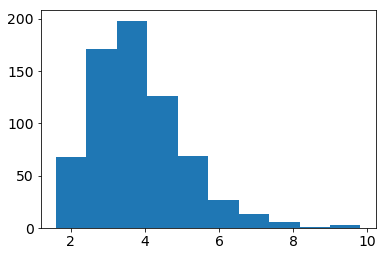

In [665]:
all_dist, example_dists = compute_wv_similarity(vgg_seg_wv, googlenet_seg_wv)
print all_dist
f, ax = plt.subplots(1,1)
ax.hist(example_dists)
plt.show()

In [341]:
d1, d2 = compute_wv_similarity(vgg_seg_wv, vggp_seg_wv)
dists = np.array([np.linalg.norm(d1[i]-d2[i]) for i in range(d1.shape[0])])
print np.linalg.norm(d1-d2)
f, ax = plt.subplots(1,1)
ax.hist(dists)
plt.show()

IndexError: tuple index out of range

In [44]:
indexes, metrics = wv.cosine('black-c', n=10)
for i in range(len(indexes)):
    print wv.vocab[indexes[i]], categories[pc[seg_idx[indexes[i]]]], metrics[i] 
#wv_disc_in.generate_response(indexes, metrics).tolist()

leather material 0.454676
swivel chair object 0.404266
cannon object 0.400729
horse-drawn carriage object 0.372844
motorbike object 0.359565
fireplace object 0.344212
wheel part 0.319464
chair object 0.314351
television object 0.303889
car object 0.287998


In [294]:
alexnet_seg_max_idx, alexnet_seg_mean_idx = sort_concepts(alexnet_seg_wv)

In [295]:
list_nearest_neighbors(alexnet_seg_wv, alexnet_seg_max_idx[::-1], 10)

tvmonitor screen 0.91354
screen tvmonitor 0.91354
toilet lid 0.880622
lid toilet 0.880622
horse cow 0.875785
cow horse 0.875785
cradle safety side 0.870132
safety side cradle 0.870132
text trade name 0.863765
trade name text 0.863765


In [296]:
list_nearest_neighbors(alexnet_seg_wv, alexnet_seg_mean_idx[::-1], 10)

airplane body 0.783149
motorbike bicycle 0.683741
boat airplane 0.688624
wing bird 0.738773
body airplane 0.783149
building house 0.766906
coffee table table 0.690016
table top 0.758519
armchair back 0.783754
truck van 0.705785


In [297]:
list_nearest_neighbors(alexnet_seg_wv, alexnet_seg_max_idx, 10)

microphone ear 0.158084
blinds stairway 0.157514
system ring 0.162977
finger slot machine 0.176022
microwave monitoring device 0.177199
mouse tumble dryer 0.179635
knob eye 0.18296
tap pavilion 0.18478
menu curb 0.177904
dishrag terraces 0.187883


In [298]:
list_nearest_neighbors(alexnet_seg_wv, alexnet_seg_mean_idx, 10)

control tower folding door 0.167242
rope skittle alley 0.166473
diffusor doors 0.160476
system ring 0.162977
canister bottle rack 0.196474
rocking chair skeleton 0.19005
parasol gravestone 0.215135
wall socket bar 0.150798
paper towel helicopter 0.218887
candelabrum faucet 0.193102


In [300]:
list_k_nearest_neighbors(alexnet_seg_wv, 'microphone', 10)

microphone ear 0.158084
microphone pictures 0.157992
microphone shower stall 0.155423
microphone engine 0.153503
microphone pitcher 0.146672
microphone fork 0.134299
microphone head 0.134271
microphone cart 0.127651
microphone eye 0.126209
microphone fluorescent 0.125585


In [301]:
list_k_nearest_neighbors(alexnet_seg_wv, 'control tower', 10)

control tower folding door 0.167242
control tower terrace 0.143352
control tower podium 0.127825
control tower wineglass 0.127673
control tower hoof 0.119445
control tower meat 0.116061
control tower revolving door 0.111971
control tower printer 0.110645
control tower cactus 0.109269
control tower jersey 0.107212


In [342]:
def show_nearest_farthest_neighbors(wv):
    max_idx, mean_idx = sort_concepts(wv)
    print 'top 10 via max'
    list_nearest_neighbors(wv, max_idx[::-1], 10)
    print '\ntop 10 via mean'
    list_nearest_neighbors(wv, mean_idx[::-1], 10)
    print '\nbottom 5 via max'
    list_nearest_neighbors(wv, max_idx, 5)
    print '\nbottom 5 via mean'
    list_nearest_neighbors(wv, mean_idx, 5)

In [313]:
show_nearest_farthest_neighbors(alexnet_seg_wv)

top 10 via max
tvmonitor screen 0.91354
screen tvmonitor 0.91354
toilet lid 0.880622
lid toilet 0.880622
horse cow 0.875785
cow horse 0.875785
cradle safety side 0.870132
safety side cradle 0.870132
text trade name 0.863765
trade name text 0.863765

top 10 via mean
airplane body 0.783149
motorbike bicycle 0.683741
boat airplane 0.688624
wing bird 0.738773
body airplane 0.783149
building house 0.766906
coffee table table 0.690016
table top 0.758519
armchair back 0.783754
truck van 0.705785

bottom 5 via max
microphone ear 0.158084
blinds stairway 0.157514
system ring 0.162977
finger slot machine 0.176022
microwave monitoring device 0.177199

bottom 5 via mean
control tower folding door 0.167242
rope skittle alley 0.166473
diffusor doors 0.160476
system ring 0.162977
canister bottle rack 0.196474


In [343]:
show_nearest_farthest_neighbors(caffe_seg_wv)

top 10 via max
tvmonitor screen 0.8951
screen tvmonitor 0.8951
toilet lid 0.802933
lid toilet 0.802933
horse cow 0.878668
cow horse 0.878668
cradle safety side 0.80411
safety side cradle 0.80411
text trade name 0.853827
trade name text 0.853827

top 10 via mean
airplane body 0.738152
motorbike bicycle 0.734072
boat airplane 0.66217
wing bird 0.732651
body airplane 0.738152
building house 0.766899
coffee table table 0.69265
table desk 0.766429
armchair back 0.790674
truck van 0.777153

bottom 5 via max
microphone button panel 0.246737
blinds display board 0.224721
system video player 0.31318
finger shop window 0.217951
microwave television 0.350983

bottom 5 via mean
control tower rubble 0.160293
rope coat 0.181532
diffusor light 0.669954
system video player 0.31318
canister soap dispenser 0.225276


In [344]:
show_nearest_farthest_neighbors(caffe_class_wv)

top 10 via max
drinking glass napkin 0.37409
top drawer 0.537215
motorbike helmet 0.311893
step fan 0.272134
trade name shop window 0.510415
can pigeonhole 0.251924
office-s computer case 0.67235
greenhouse-indoor-s greenhouse 0.616797
case cash register 0.302437
stool floor 0.421246

top 10 via mean
van street-s 0.429282
oven kitchen-s 0.628698
bench wall 0.343087
bicycle handle bar 0.517133
faucet sink 0.734737
building sky 0.612626
stove kitchen-s 0.671646
table chair 0.608243
dog muzzle 0.611722
cup plate 0.498769

bottom 5 via max
marbled stained 0.448471
field-wild-s field-cultivated-s 0.805631
cracked cobwebbed 0.475167
warehouse-indoor-s merchandise 0.732342
shop window trade name 0.510415

bottom 5 via mean
grand piano lobby-s 0.392827
inside arm outside arm 0.872217
embankment ruin-s 0.43695
cracked cobwebbed 0.475167
scaly knitted 0.52977


In [116]:
import seaborn as sns

In [275]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [183]:
seg_dist = np.dot(wv.vectors, wv.vectors.T)
class_dist = np.dot(wv_disc.vectors[seg_idx-1], wv_disc.vectors[seg_idx-1].T)
vgg_seg_dist = np.dot(vgg_wv.vectors, vgg_wv.vectors.T)

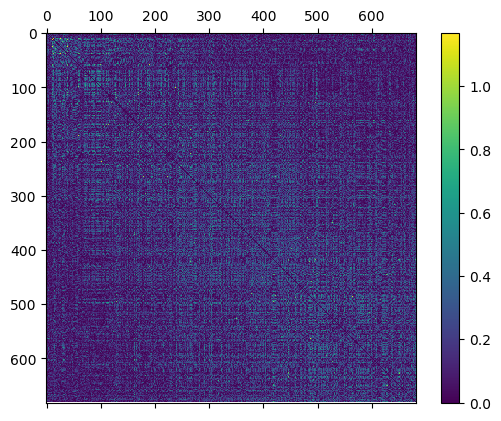

In [132]:
diff = np.abs(seg_dist-class_dist)

f, ax = plt.subplots(1,1)
cax = ax.matshow(diff)
f.colorbar(cax)
plt.show()

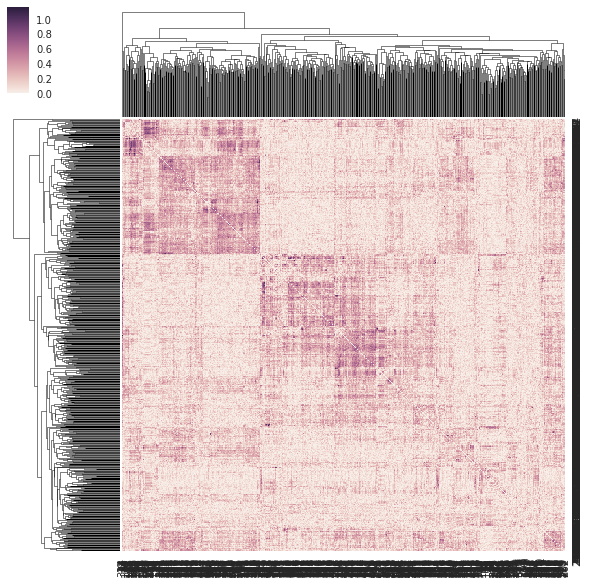

In [120]:
g = sns.clustermap(diff)

In [125]:
label_names[seg_idx[g.dendrogram_col.reordered_ind][:100]]

array([u'sky', u'cloud', u'flower', u'plant', u'flowerpot', u'column',
       u'double door', u'mirror', u'windowpane', u'door', u'house',
       u'shutter', u'wall', u'curtain', u'wardrobe', u'fireplace',
       u'door frame', u'lower sash', u'pane', u'sash', u'painting',
       u'television', u'frame', u'shelf', u'bookcase', u'cabinet', u'book',
       u'glass', u'painted', u'wallpaper', u'floor', u'ceiling', u'light',
       u'desk', u'swivel chair', u'top', u'coffee table', u'armchair',
       u'ottoman', u'seat cushion', u'back pillow', u'inside arm',
       u'seat base', u'outside arm', u'blanket', u'chest', u'eiderdown',
       u'bed', u'cushion', u'pillow', u'carpet', u'sofa', u'fabric',
       u'leather', u'table', u'chair', u'back', u'seat', u'pitcher',
       u'teapot', u'jar', u'fruit', u'bouquet', u'canister',
       u'table cloth', u'oven', u'dishwasher', u'work surface',
       u'kitchen island', u'bottle rack', u'baseboard', u'panel', u'stove',
       u'button panel', u

In [130]:
from scipy.spatial.distance import hamming

In [135]:
sorted_seg_dist_idx = np.array([np.argsort(seg_dist[i]) for i in range(len(seg_idx))])
sorted_class_dist_idx = np.array([np.argsort(class_dist[i]) for i in range(len(seg_idx))])

In [139]:
hamming_dists = np.array([hamming(sorted_seg_dist_idx[i], sorted_class_dist_idx[i]) for i in range(len(seg_idx))])

In [146]:
seg_dist[0].shape

(682,)

In [198]:
#dists = np.array([np.dot((1-seg_dist[i]),(1-class_dist[i]).T) for i in range(len(seg_idx))])
#dists = np.array([np.linalg.norm(seg_dist[i]-vgg_seg_dist[i]) for i in range(len(seg_idx))])
dists = np.array([np.linalg.norm(seg_dist[i]/np.linalg.norm(seg_dist[i])-vgg_seg_dist[i]/np.linalg.norm(seg_dist[i])) for i in range(len(seg_idx))])

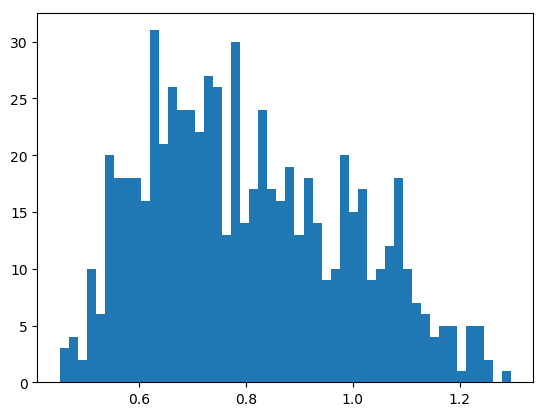

In [199]:
f, ax = plt.subplots(1,1)
ax.hist(dists, bins=50)
plt.show()

In [200]:
sorted_idx = np.argsort(dists)

In [201]:
num_top = 10

for i in range(10):
    print label_names[seg_idx[sorted_idx[i]]], dists[sorted_idx[i]]
        
print ''

for i in range(10):
    print label_names[seg_idx[sorted_idx[-(i+1)]]], dists[sorted_idx[-(i+1)]]

airplane 0.451716
building 0.45533
wall 0.468558
train 0.471082
boat 0.476965
cow 0.483039
headlight 0.484842
armchair 0.490402
truck 0.492041
mirror 0.506519

tomb 1.29601
pulpit 1.25079
towel rack 1.24671
spoon 1.24371
bread 1.23916
pitcher 1.23585
computer case 1.23518
can 1.23165
fish 1.22612
tire 1.22274


In [193]:
mus = np.zeros(4)
sigmas = np.zeros(4)
stderr = np.zeros(4)
print '%10s\t%s\t%s\t%s\t' % ('', 'mean', 'std', r'stderr')
for c in range(4):
    mus[c] = np.mean(dists[pc[seg_idx] == c])
    sigmas[c] = np.std(dists[pc[seg_idx] == c])
    stderr[c] = sigmas[c]/np.sqrt(len(pc[seg_idx] == c))
    print '%10s\t%.2f\t%.4f\t%.4f' % (categories[c], mus[c], sigmas[c], stderr[c])

          	mean	std	stderr	
     color	1.78	0.0876	0.0034
    object	2.19	0.2017	0.0077
      part	2.19	0.2445	0.0094
  material	2.11	0.2044	0.0078


In [170]:
def cos_dist(word, wv_obj, sel_idx, n=10):
    indexes, metrics = wv_obj.cosine(word, n=n)
    for i in range(len(indexes)):
        print wv_obj.vocab[indexes[i]], categories[pc[sel_idx[indexes[i]]]], metrics[i]

In [202]:
cos_dist('airplane', wv, seg_idx)
print ''
cos_dist('airplane', vgg_wv, seg_idx)

body part 0.783149
engine part 0.707972
stern part 0.696414
boat object 0.688624
wing part 0.673566
fuselage part 0.660548
car object 0.600343
motorbike object 0.595616
plane object 0.563728
truck object 0.520949

body part 0.691438
engine part 0.686644
plane object 0.635388
stern part 0.618461
wing part 0.60146
fuselage part 0.594015
boat object 0.582704
motorbike object 0.463546
helicopter object 0.45236
train object 0.443896


In [203]:
cos_dist('tomb', wv, seg_idx)
print ''
cos_dist('tomb', vgg_wv, seg_idx)

pool table object 0.318246
aquarium object 0.291018
swimming pool object 0.271948
awning object 0.266522
ashcan object 0.266297
pool object 0.254667
wave part 0.202723
green-c color 0.193952
grand piano object 0.193579
cockpit object 0.190627

footboard part 0.358079
back part 0.333112
ottoman object 0.3182
bed object 0.312773
bench object 0.303147
seat cushion part 0.302988
sandbox object 0.301254
outside arm part 0.297627
blanket object 0.295669
stairs object 0.27528


In [195]:
cos_dist('mouth', wv, seg_idx)
print ''
cos_dist('mouth', vgg_wv, seg_idx)

eyebrow part 0.730355
nose part 0.666821
hair part 0.575574
oar object 0.487032
skin material 0.444867
neck part 0.435686
eye part 0.435123
hand part 0.434219
person object 0.390055
head part 0.377531

eyebrow part 0.649734
nose part 0.608135
hair part 0.455352
head part 0.410574
neck part 0.409596
eye part 0.373142
person object 0.259646
pink-c color 0.242383
skin material 0.233416
oar object 0.223458


In [194]:
cos_dist('ear', wv, seg_idx)
print ''
cos_dist('ear', vgg_wv, seg_idx)

dog object 0.722989
fur material 0.694768
neck part 0.660355
cat object 0.647617
tail part 0.638285
head part 0.613582
horse object 0.578203
cow object 0.572834
sheep object 0.556808
hair part 0.543081

head part 0.55322
dog object 0.50692
hair part 0.493833
cat object 0.403205
neck part 0.306939
sky object 0.306257
horse object 0.285498
horn part 0.280254
eye part 0.27762
cow object 0.268565


In [173]:
cos_dist('cloud', wv, seg_idx)
print ''
cos_dist('cloud', wv_disc, range(1,L))

clouds part 0.700948
sky object 0.493723
fog bank object 0.492024
blue-c color 0.283066
smoke object 0.217846
white-c color 0.19808
leaves object 0.139584
painted material 0.124346
price tag object 0.122939
candelabrum object 0.121186

industrial_park-s scene 0.669658
parking lot object 0.643594
airport-entrance-s scene 0.639512
clouds part 0.634422
billboard object 0.61838
lighthouse object 0.616984
lighthouse-s scene 0.614687
control tower object 0.607875
bank-outdoor-s scene 0.606297
parking object 0.605308


In [174]:
cos_dist('purple-c', wv, seg_idx)
print ''
cos_dist('purple-c', wv_disc, range(1,L))

red-c color 0.51856
pink-c color 0.448138
seat object 0.407561
meat object 0.363573
blue-c color 0.343861
flag object 0.340805
grandstand object 0.336174
bedclothes object 0.324358
bed object 0.313384
fabric material 0.307845

blue-c color 0.551442
pink-c color 0.546416
grey-c color 0.483582
brown-c color 0.311612
black-c color 0.308786
red-c color 0.292877
white-c color 0.212937
gym shoe object 0.209577
baby buggy object 0.20847
spotlight object 0.201393


## Mean K-Nearest Concept Categories

In [211]:
def compute_mean_nearest_categories(wv_obj, sel_idx, num_nearest=10, num_cats=6, title=None):
    nearest_cats = np.zeros((L, num_nearest))
    for i in range(len(sel_idx)):
        indexes, metrics = wv_obj.cosine(label_names[sel_idx[i]], n=num_nearest)
        for j in range(num_nearest):
            nearest_cats[sel_idx[i]][j] = pc[sel_idx[indexes[j]]]
    mean_nearest_cats = np.zeros((num_cats,num_cats))
    for c1 in range(num_cats):
        for c2 in range(num_cats):
            mean_nearest_cats[c1][c2] = np.sum(nearest_cats[pc == c1] == c2)/float(num_nearest*np.sum(pc == c1))
    print ('%10s\t' + '%s\t' * num_cats) % tuple(np.concatenate(([''], [c[:7] for c in categories[:num_cats]]), axis=0))
    for cat in range(num_cats):
        print ('%10s\t' + '%s\t' * num_cats) % tuple(np.concatenate(([categories[cat]], 
                                                                     ['%.2f' % x for x in mean_nearest_cats[cat]]), 
                                                                    axis=0))
    f, ax = plt.subplots(1,1, figsize=(num_cats+2,num_cats))
    if title is not None:
        ax.set_xlabel(title)
    cax = ax.matshow(mean_nearest_cats, vmin=0.0, vmax=1.0)
    f.colorbar(cax)
    plt.xticks(range(num_cats), categories[:num_cats])#, rotation='vertical')
    plt.yticks(range(num_cats), categories[:num_cats], rotation='vertical', verticalalignment='center')
    plt.tick_params(
        axis='x',
        which='both',
        bottom='off',
        top='off') 
    plt.tick_params(
        axis='y',
        which='both',
        left='off',
        right='off')
    plt.show()
    return (nearest_cats, mean_nearest_cats)

          	color	object	part	materia	
     color	0.31	0.49	0.09	0.11	
    object	0.01	0.79	0.16	0.04	
      part	0.01	0.57	0.40	0.02	
  material	0.03	0.56	0.14	0.26	


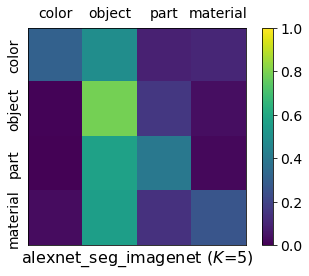

          	color	object	part	materia	
     color	0.44	0.35	0.05	0.16	
    object	0.01	0.82	0.14	0.04	
      part	0.00	0.61	0.34	0.04	
  material	0.02	0.57	0.16	0.25	


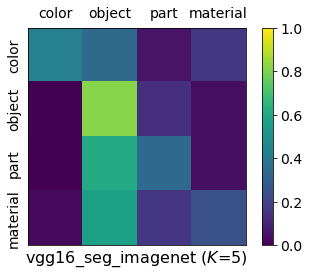

          	color	object	part	materia	
     color	0.40	0.42	0.07	0.11	
    object	0.01	0.80	0.16	0.03	
      part	0.01	0.51	0.45	0.03	
  material	0.02	0.54	0.18	0.26	


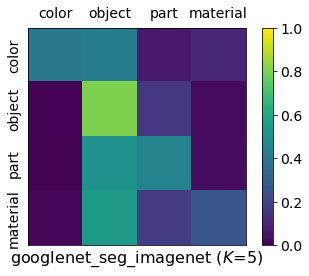

In [345]:
num_nearest=5
_,_ = compute_mean_nearest_categories(caffe_seg_wv, seg_idx, num_nearest=num_nearest, num_cats=4,
                                      title='alexnet_seg_imagenet ($K$=%d)' % num_nearest)
_,_ = compute_mean_nearest_categories(vgg_seg_wv, seg_idx, num_nearest=num_nearest, num_cats=4,
                                      title='vgg16_seg_imagenet ($K$=%d)' % num_nearest)
_,_ = compute_mean_nearest_categories(googlenet_seg_wv, seg_idx, num_nearest=num_nearest, num_cats=4,
                                      title='googlenet_seg_imagenet ($K$=%d)' % num_nearest)

          	color	object	part	materia	
     color	0.40	0.44	0.05	0.11	
    object	0.01	0.81	0.15	0.04	
      part	0.01	0.61	0.35	0.04	
  material	0.02	0.54	0.18	0.27	


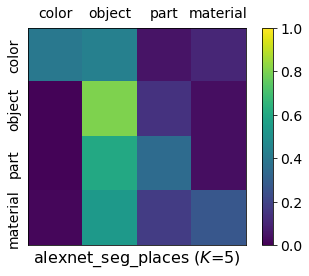

          	color	object	part	materia	
     color	0.44	0.35	0.09	0.13	
    object	0.01	0.82	0.14	0.03	
      part	0.00	0.56	0.41	0.03	
  material	0.02	0.58	0.17	0.24	


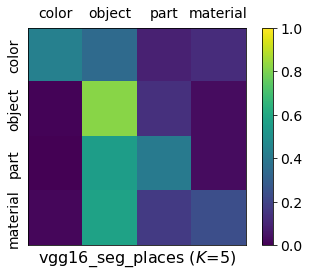

          	color	object	part	materia	
     color	0.38	0.40	0.09	0.13	
    object	0.01	0.77	0.19	0.03	
      part	0.00	0.51	0.46	0.03	
  material	0.02	0.46	0.21	0.31	


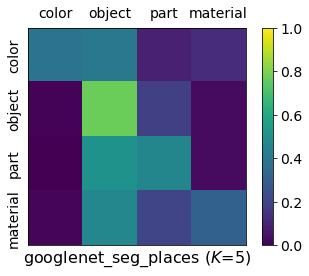

In [346]:
num_nearest=5
_,_ = compute_mean_nearest_categories(caffep_seg_wv, seg_idx, num_nearest=num_nearest, num_cats=4,
                                      title='alexnet_seg_places ($K$=%d)' % num_nearest)
_,_ = compute_mean_nearest_categories(vggp_seg_wv, seg_idx, num_nearest=num_nearest, num_cats=4,
                                      title='vgg16_seg_places ($K$=%d)' % num_nearest)
_,_ = compute_mean_nearest_categories(googlenetp_seg_wv, seg_idx, num_nearest=num_nearest, num_cats=4,
                                      title='googlenet_seg_places ($K$=%d)' % num_nearest)

          	color	object	part	materia	scene	texture	
     color	0.73	0.16	0.00	0.00	0.11	0.00	
    object	0.00	0.50	0.13	0.00	0.36	0.00	
      part	0.00	0.32	0.53	0.00	0.16	0.00	
  material	0.00	0.23	0.06	0.63	0.07	0.00	
     scene	0.00	0.29	0.04	0.00	0.66	0.01	
   texture	0.00	0.01	0.00	0.00	0.12	0.86	


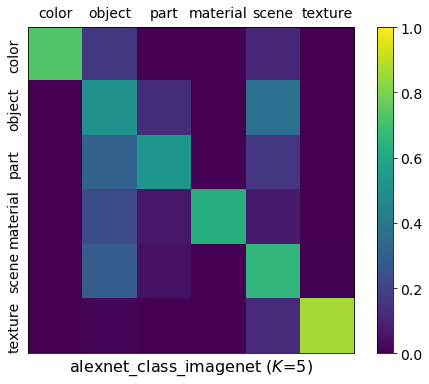

          	color	object	part	materia	scene	texture	
     color	0.96	0.04	0.00	0.00	0.00	0.00	
    object	0.00	0.41	0.11	0.00	0.47	0.00	
      part	0.00	0.27	0.47	0.00	0.26	0.00	
  material	0.00	0.31	0.07	0.44	0.18	0.00	
     scene	0.00	0.24	0.03	0.00	0.72	0.00	
   texture	0.00	0.09	0.00	0.00	0.50	0.41	


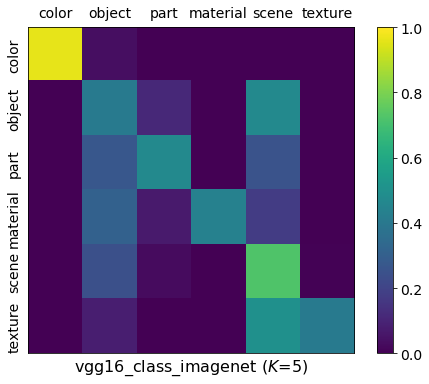

          	color	object	part	materia	scene	texture	
     color	0.96	0.04	0.00	0.00	0.00	0.00	
    object	0.00	0.45	0.10	0.00	0.44	0.00	
      part	0.00	0.27	0.50	0.00	0.23	0.00	
  material	0.00	0.27	0.01	0.46	0.26	0.00	
     scene	0.00	0.26	0.03	0.00	0.70	0.00	
   texture	0.00	0.03	0.00	0.00	0.24	0.73	


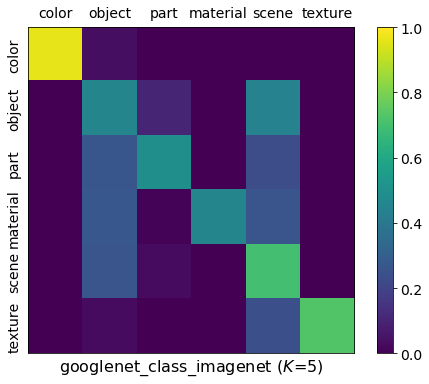

In [218]:
num_nearest=5
_,_ = compute_mean_nearest_categories(alexnet_class_wv, range(1,L), num_nearest=num_nearest, num_cats=6,
                                     title='alexnet_class_imagenet ($K$=%d)' %  (num_nearest))
_,_ = compute_mean_nearest_categories(vgg_class_wv, range(1,L), num_nearest=num_nearest, num_cats=6,
                                     title='vgg16_class_imagenet ($K$=%d)' %  (num_nearest))
_,_ = compute_mean_nearest_categories(googlenet_class_wv, range(1,L), num_nearest=num_nearest, num_cats=6,
                                     title='googlenet_class_imagenet ($K$=%d)' %  (num_nearest))

          	color	object	part	materia	scene	texture	
     color	0.76	0.11	0.07	0.00	0.05	0.00	
    object	0.00	0.46	0.10	0.00	0.44	0.00	
      part	0.00	0.27	0.51	0.00	0.23	0.00	
  material	0.00	0.22	0.03	0.65	0.10	0.00	
     scene	0.00	0.24	0.03	0.00	0.73	0.00	
   texture	0.00	0.02	0.00	0.00	0.28	0.70	


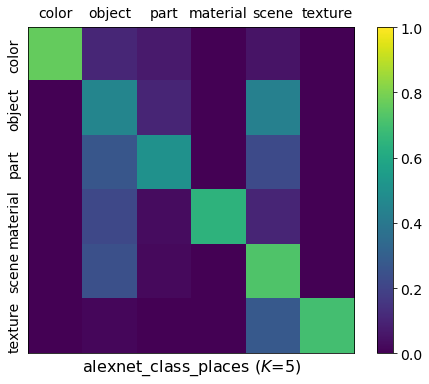

          	color	object	part	materia	scene	texture	
     color	0.91	0.05	0.02	0.00	0.02	0.00	
    object	0.00	0.42	0.11	0.00	0.46	0.00	
      part	0.00	0.24	0.50	0.00	0.26	0.00	
  material	0.00	0.29	0.03	0.51	0.17	0.00	
     scene	0.00	0.26	0.04	0.00	0.70	0.01	
   texture	0.00	0.09	0.00	0.00	0.41	0.51	


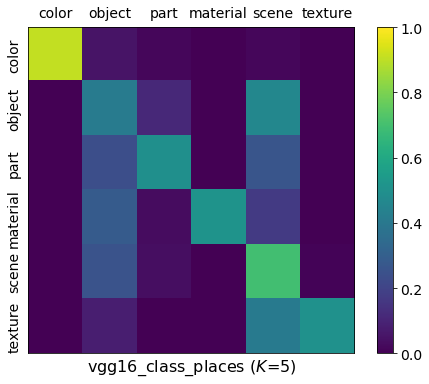

          	color	object	part	materia	scene	texture	
     color	1.00	0.00	0.00	0.00	0.00	0.00	
    object	0.00	0.44	0.11	0.00	0.44	0.00	
      part	0.00	0.28	0.51	0.00	0.21	0.00	
  material	0.00	0.29	0.02	0.46	0.22	0.01	
     scene	0.00	0.24	0.03	0.00	0.72	0.00	
   texture	0.00	0.03	0.00	0.00	0.09	0.88	


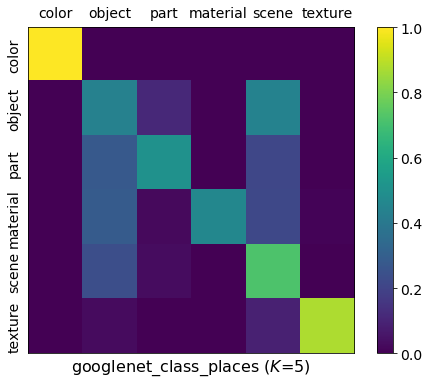

In [219]:
num_nearest=5
_,_ = compute_mean_nearest_categories(caffep_class_wv, range(1,L), num_nearest=num_nearest, num_cats=6,
                                     title='alexnet_class_places ($K$=%d)' %  (num_nearest))
_,_ = compute_mean_nearest_categories(vggp_class_wv, range(1,L), num_nearest=num_nearest, num_cats=6,
                                     title='vgg16_class_places ($K$=%d)' %  (num_nearest))
_,_ = compute_mean_nearest_categories(googlenetp_class_wv, range(1,L), num_nearest=num_nearest, num_cats=6,
                                     title='googlenet_class_places ($K$=%d)' %  (num_nearest))